# 5. Matrix Factorization Visualizations

Let m, n be the number of users and movies, respectively, and Y be the m x n matrix of the movie ratings,
where yij corresponds to user i’s rating for the movie j. Note that most of the elements of the matrix are
unknown. The goal of a recommender system is to predict these missing values.
Your job is to find the matrices U and V, such that Y ' UT V . Note that U has dimension k  m and V
has dimension k  n. You must try at least three methods for finding U and V.
1. Use (and/or modify) your code for Homework 5.
2. Incorporate bias terms a and b for each user and movie, to model global tendencies of the various
users and movies. See the guide for more information. You should write your own implementation
of this method.
3. Use an off-the-shelf implementation1. Google ”collaborative filtering python,” ”collaborative filtering
matlab,” etc. to see examples. Note that in this assignment, we want you to try an off-the-shelf matrix
factorization method, rather than any collaborative filtering method in general.

For the first two methods, choose k = 20, and justify your choices for any other parameters and the
stopping criteria you use. For all of these methods, split the MovieLens dataset into a training set (of size
90,000) and a test set (of size 10,000), as given in the files train.txt and test.txt. You should then compare
these methods by assessing their performance on the test set. Once you have obtained U; V , you will
attempt to visualize and interpret your results.
1. In order to visualize the resulting latent factors, apply SVD to V = AB and use the first two columns
of A to project U, V into a two-dimensional space. This projection is given by ~U = AT
1:2U 2 R2m and
~ V = AT
1:2V 2 R2n.
2. Now, construct creative 2D-visualizations of ~ V , similar to the one in Figure 2 of the reference [1]. For
each of the three matrix factorization methods, visualize the following:
(a) Any ten movies of your choice from the MovieLens dataset.
(b) The ten most popular movies (movies which have received the most ratings).
(c) The ten best movies (movies with the highest average ratings).
(d) Ten movies from the three genres you selected in Section 4, Basic Visualizations (for a total of 30
movies). Create one visualization, containing ten movies, for each of the three genres you select.

In [1]:
import sys
sys.path.append('..')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns

from src import utils
from src import basic_SVD
from src import bias_SVD
from src import matrix_visualize
from src import film_choices

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df_data = utils.load_data()
df_train = utils.load_train_data()
df_test = utils.load_test_data()
df_movies = utils.load_movies()

### Homework 5 Question 2 Code

### Actual Visualization Code after Matrix Factorization

### Data Cleansing

This is essentially the cleansing of the data meant to deal with two main issues:
1) Some movies do not have ratings, this is handled by finding those movies and giving them a default rating of 2.5
2) Some movies have the same title but a different ID, however, this is mainly because Hollywood likes to use the same name for films, so this has been mostly ignored since they are probably different films with the same name

In [5]:
movie_ids = df_movies.movie_id.values
user_id = np.max(df_data.user_id) + 1
df_train_full = utils.add_missing_ratings(df_train, movie_ids, user_id=user_id)
df_test_full = utils.add_missing_ratings(df_test, movie_ids, user_id=user_id)

In [4]:
# df_data = utils.load_data()
# df_train = utils.load_train_data()
# df_test = utils.load_test_data()
# df_movies = utils.load_movies()

# # initial data cleansing

# # get the raw data in the form of a matrix
# raw_ratings_train = df_train.to_numpy()
# raw_ratings_test = df_test.to_numpy()

# # 1) handle the fact that some movies do not have ratings
# movies_with_ratings = np.unique(raw_ratings_train[:,1])

# max_user_id = max(max(raw_ratings_train[:,0]), max(raw_ratings_test[:,0])).astype(int) # users

# # we know that there are 1682 films
# all_films = np.array(list(range(1, 1683)))

# # loop through all the movies and determine which ones do not have a rating
# for film in movies_with_ratings:
#     all_films[film - 1] = 0
    
# films_without_ratings = np.unique(all_films)

# # we are going to add ratings for all the films without ratings and label this as a rating by an additional user
# # user number 944 to be exact who rates all these 14 missing films with a rating of 2.5
# to_add = []
# for film_wo_rating in films_without_ratings:
#     # filter out the zero that was used to identify all films with ratings
#     if (film_wo_rating == 0):
#         pass
#     else:
#         to_add.append([max_user_id + 1, film_wo_rating, 2.5])
    
# additional_df_train = pd.DataFrame(to_add, columns=list(df_train))
# # append these new default ratings with new default user to the dataframe
# df_train = df_train.append(additional_df_train, ignore_index=True)

# # TODO: handle the cleaning based on the fact that some movies have diff ID's but same title

In [5]:
popular = df_data.movie_id.value_counts().sort_values(ascending=False)[:10].index.values
best = df_data[['movie_id', 'rating']].groupby('movie_id').mean().sort_values('rating', ascending=False)[:10].index.values
popular = list(popular)
best = list(best)
print(popular)
print(best)

[49, 257, 99, 180, 293, 285, 287, 0, 299, 120]
[813, 1598, 1200, 1121, 1652, 1292, 1499, 1188, 1535, 1466]


### Matrix Factorization Visualizations Based on HW 5

In [6]:
Y_train = df_train_full.to_numpy()
Y_test = df_test_full.to_numpy()

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) + 1 # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) + 1 # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

# just to track runtime warnings
np.seterr(all='raise')

reg = 0.1
eta = 0.03 # learning rate

# actually run the code
U,V, err = basic_SVD.train_model(M, N, K, eta, reg, Y_train)
E_in = err
E_out = basic_SVD.get_err(U, V, Y_test)
print(f"The e_in for this factorization is: {E_in: 0.5f}")
print(f"The e_out for this factorization is: {E_out: 0.5f}")



Factorizing with  944  users,  1682  movies.


KeyboardInterrupt: 

Adding film Great Day in Harlem, A (1994) with index 813
Adding film Someone Else's America (1995) with index 1598
Adding film Marlene Dietrich: Shadow and Light (1996)  with index 1200
Adding film They Made Me a Criminal (1939) with index 1121
Adding film Entertaining Angels: The Dorothy Day Story (1996) with index 1652
Adding film Star Kid (1997) with index 1292
Adding film Santa with Muscles (1996) with index 1499
Adding film Prefontaine (1997) with index 1188
Adding film Aiqing wansui (1994) with index 1535
Adding film Saint of Fort Washington, The (1993) with index 1466


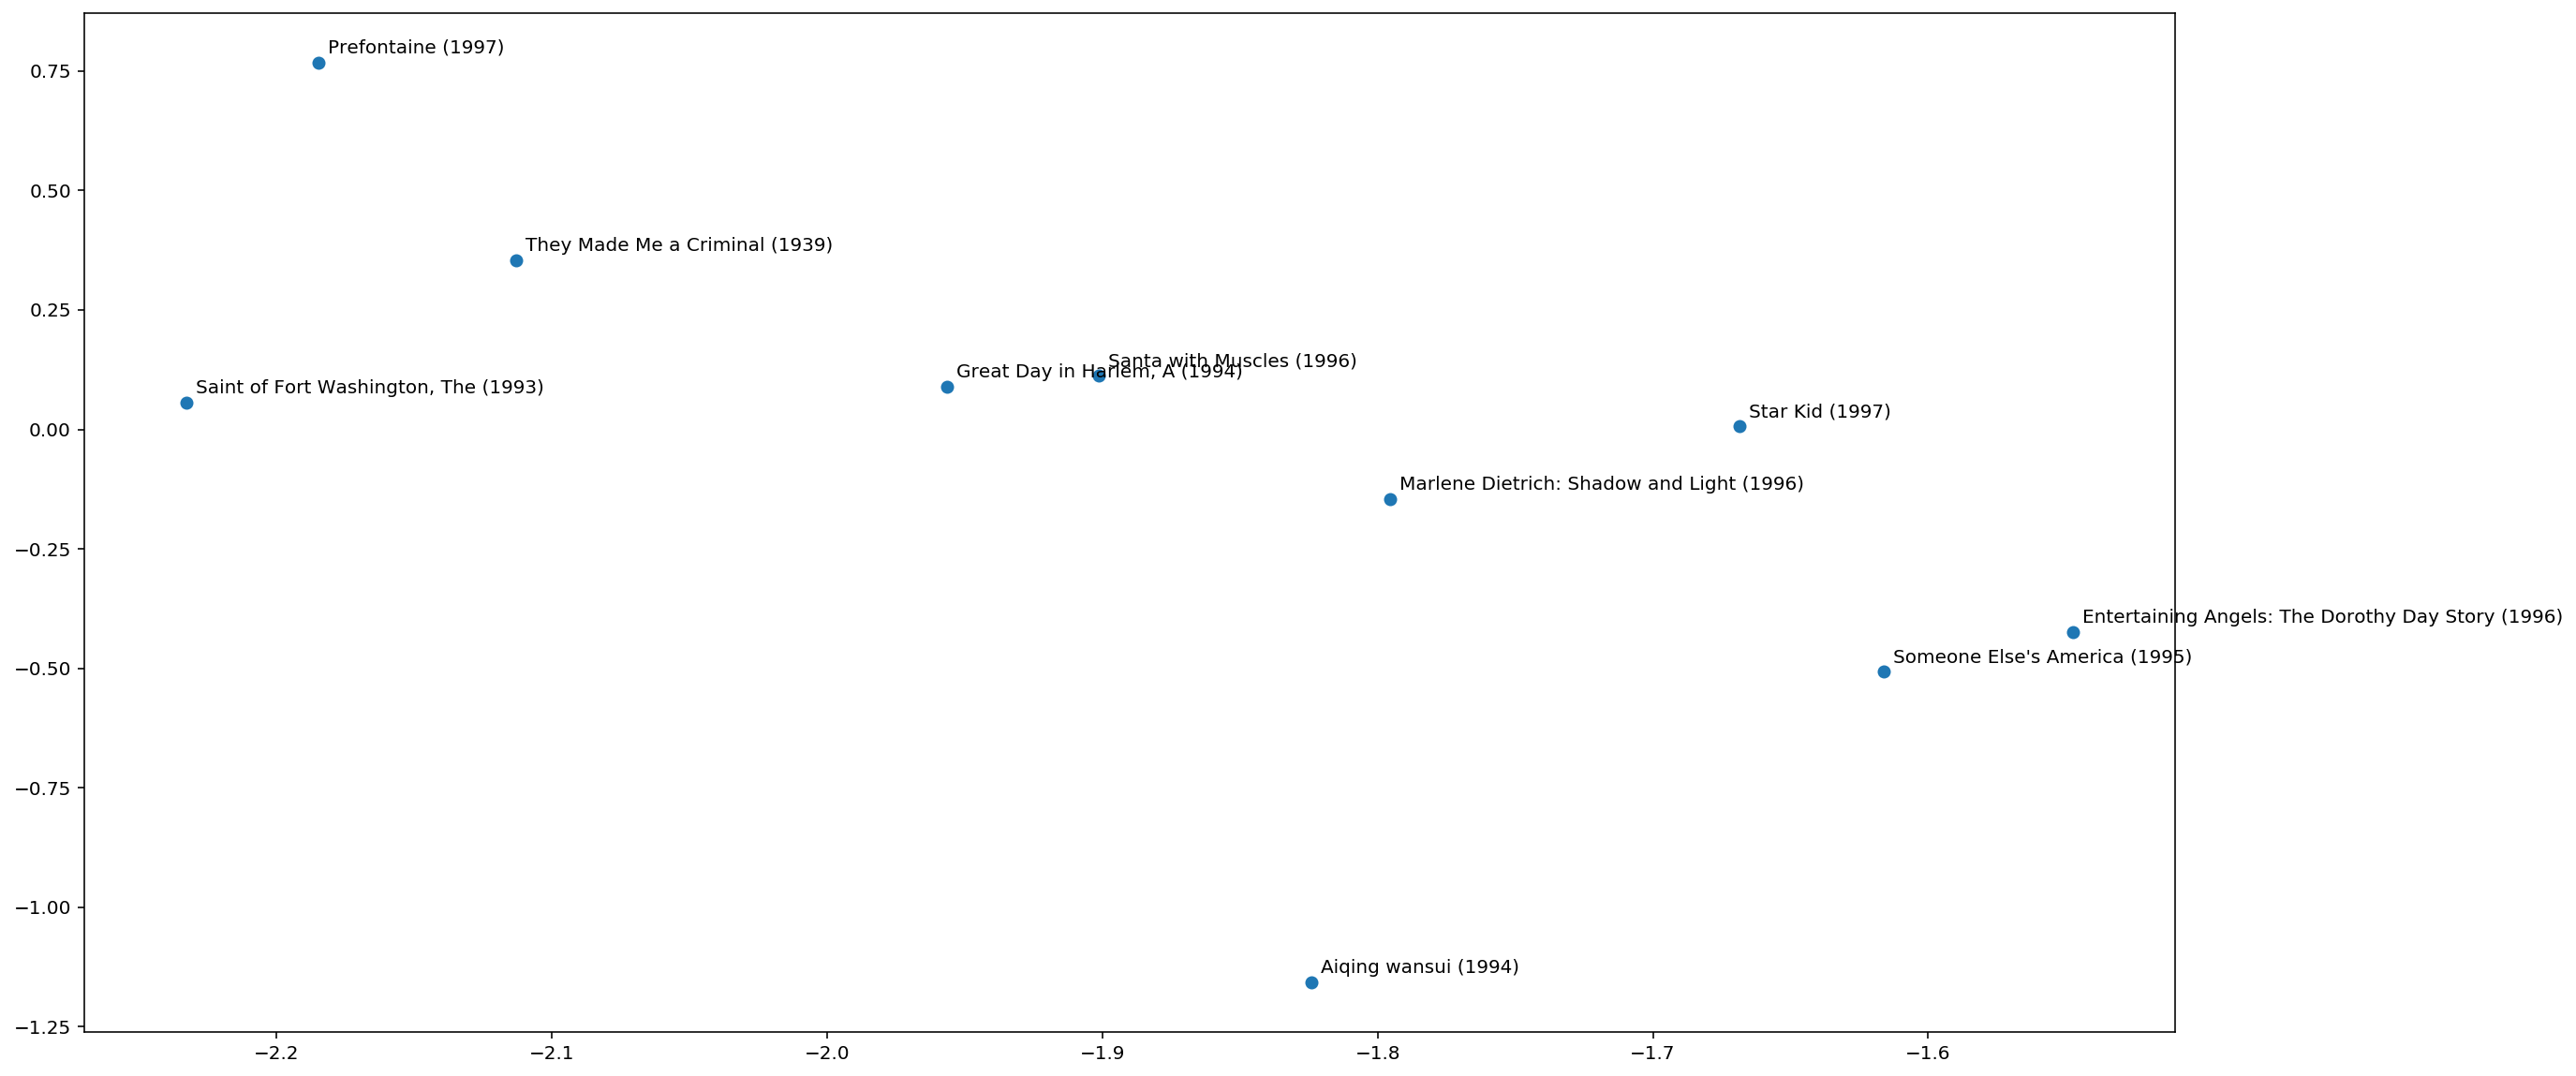

In [9]:
# attempt the visualization
matrix_visualize.plot_2d_projection_V(V.T, df_movies, best)

### Bias SVD

In [10]:
# actually run the bias case
reg = 0.1
eta = 0.03 # learning rate

# actually run the code
U,V, a, b, err = bias_SVD.train_model(M, N, K, eta, reg, Y_train, max_epochs = 50)
mu = np.mean(Y_test[:, 2])
E_in = err
E_out = bias_SVD.get_err(U, V, Y_test, a, b, mu)
print(f"The e_in for this factorization is: {E_in: 0.5f}")
print(f"The e_out for this factorization is: {E_out: 0.5f}")

Currently on epoch #5..
Currently on epoch #10..
Currently on epoch #15..
Currently on epoch #20..
Currently on epoch #25..
Currently on epoch #30..
Stopping at epoch #33
Model training is complete!
The e_in for this factorization is:  22620.78421
The e_out for this factorization is:  4246.02112


In [ ]:
# attempt the visualization
matrix_visualize.plot_2d_projection_V(V.T, df_movies, popular)

### Full Model Run

In [7]:
# run with the entire dataset
Y_full = df_data.to_numpy()
reg = 0.1
eta = 0.03 # learning rate

# actually run the code
U_basic, V_basic, err_basic = basic_SVD.train_model(M, N, K, eta, reg, Y_full, max_epochs = 50)

# perform the bias code
U_bias, V_bias, a, b, err_bias = bias_SVD.train_model(M, N, K, eta, reg, Y_full, max_epochs = 50)

Stopping at epoch #14
Model training is complete!
Currently on epoch #5..
Currently on epoch #10..
Currently on epoch #15..
Currently on epoch #20..
Currently on epoch #25..
Currently on epoch #30..
Currently on epoch #35..
Stopping at epoch #37
Model training is complete!


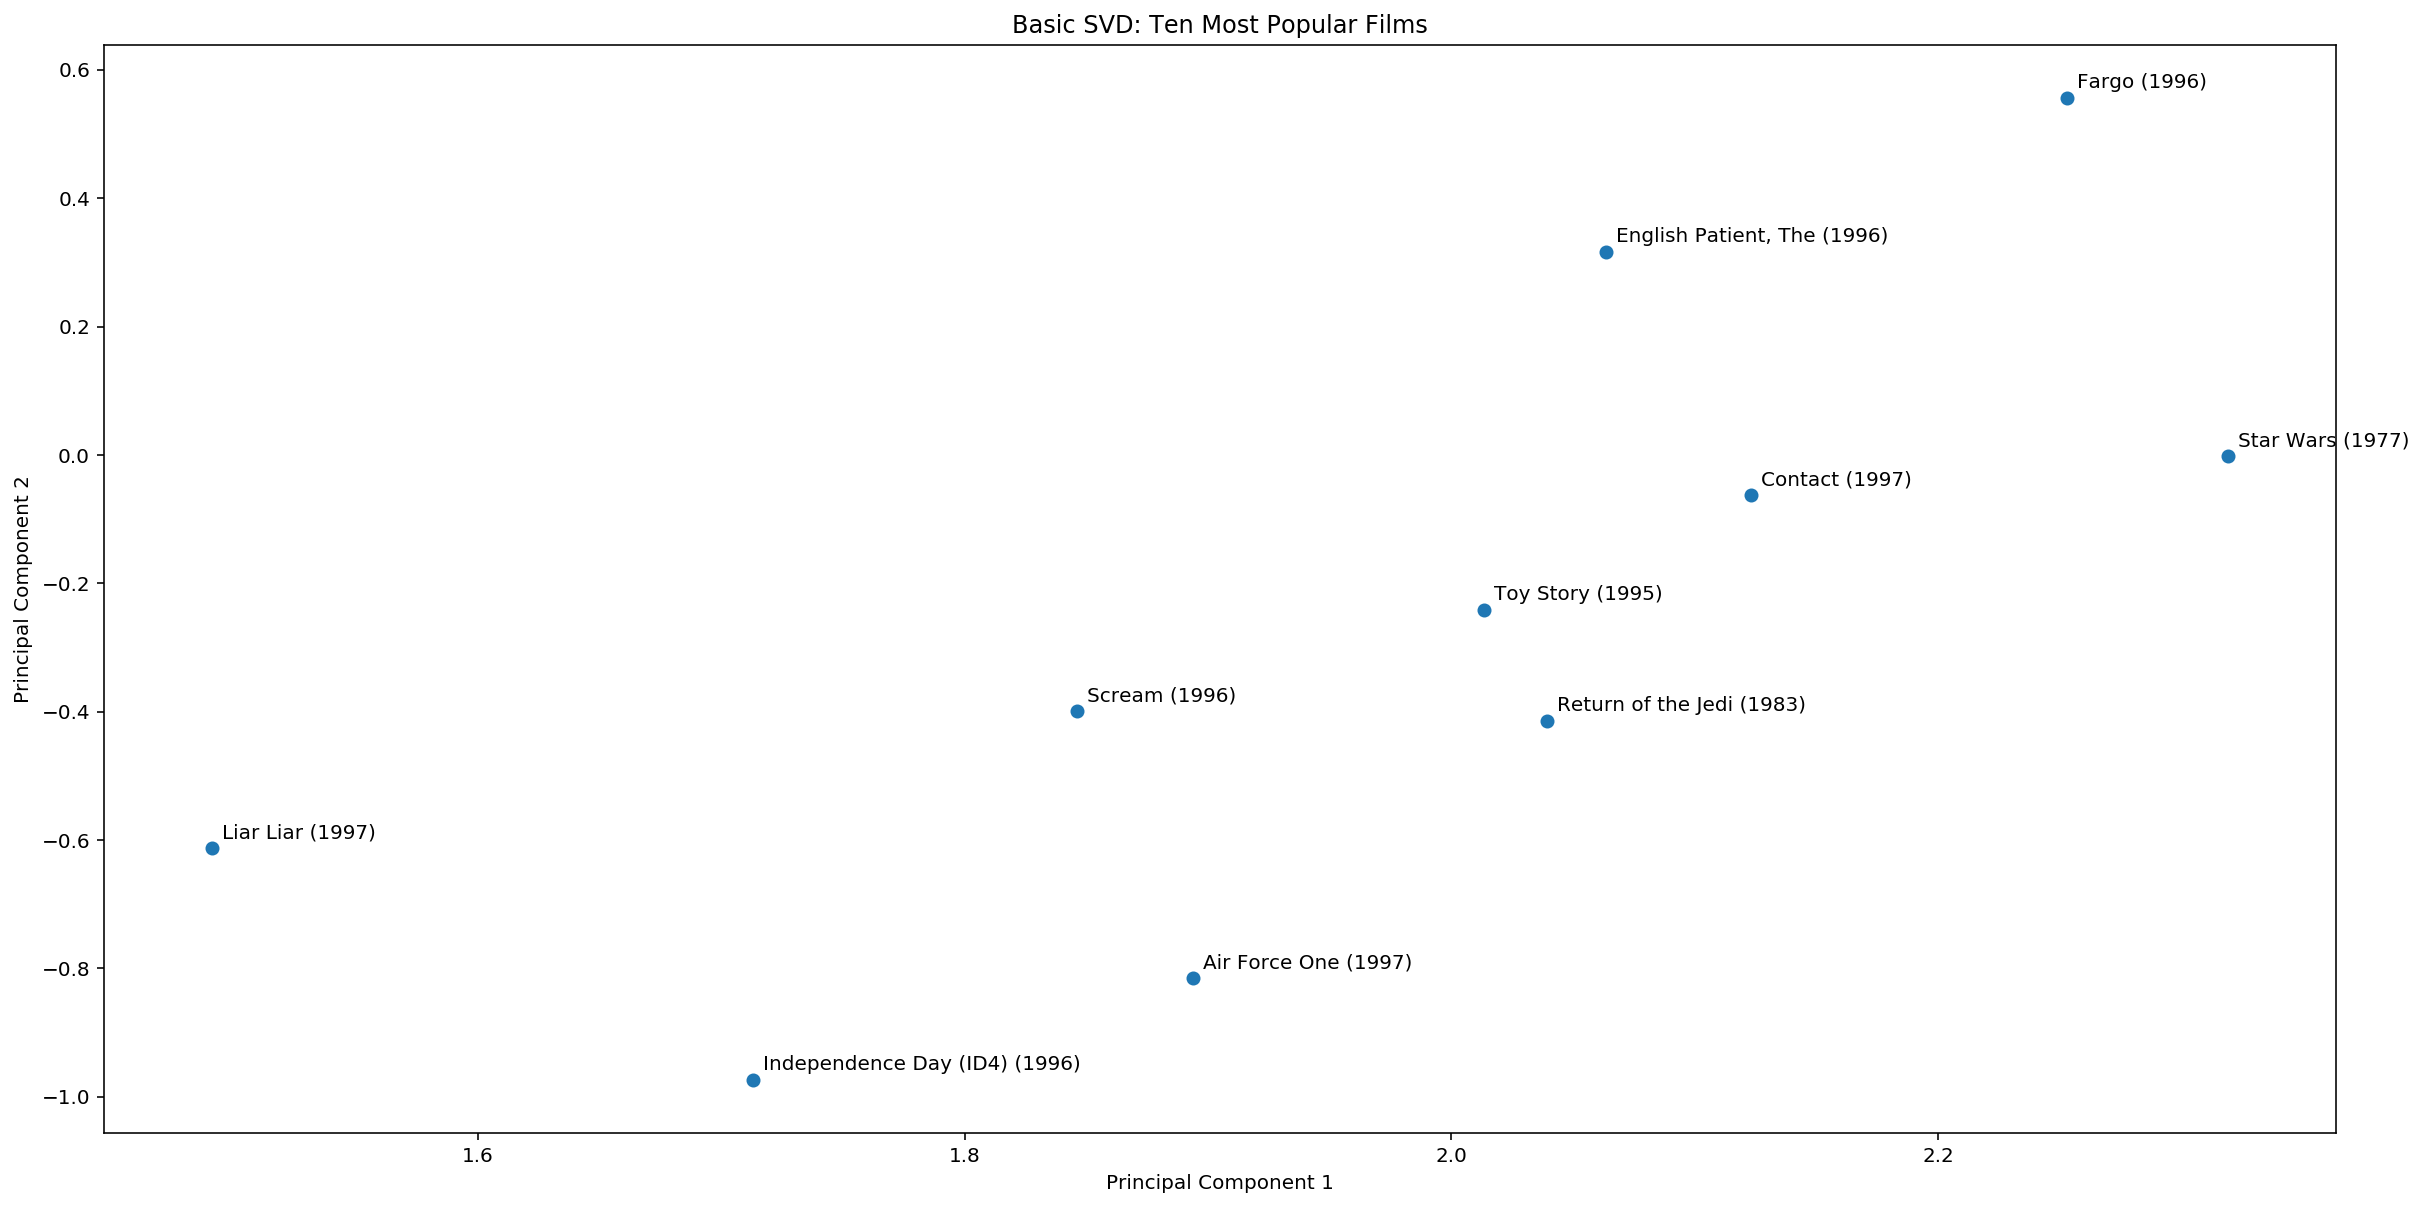

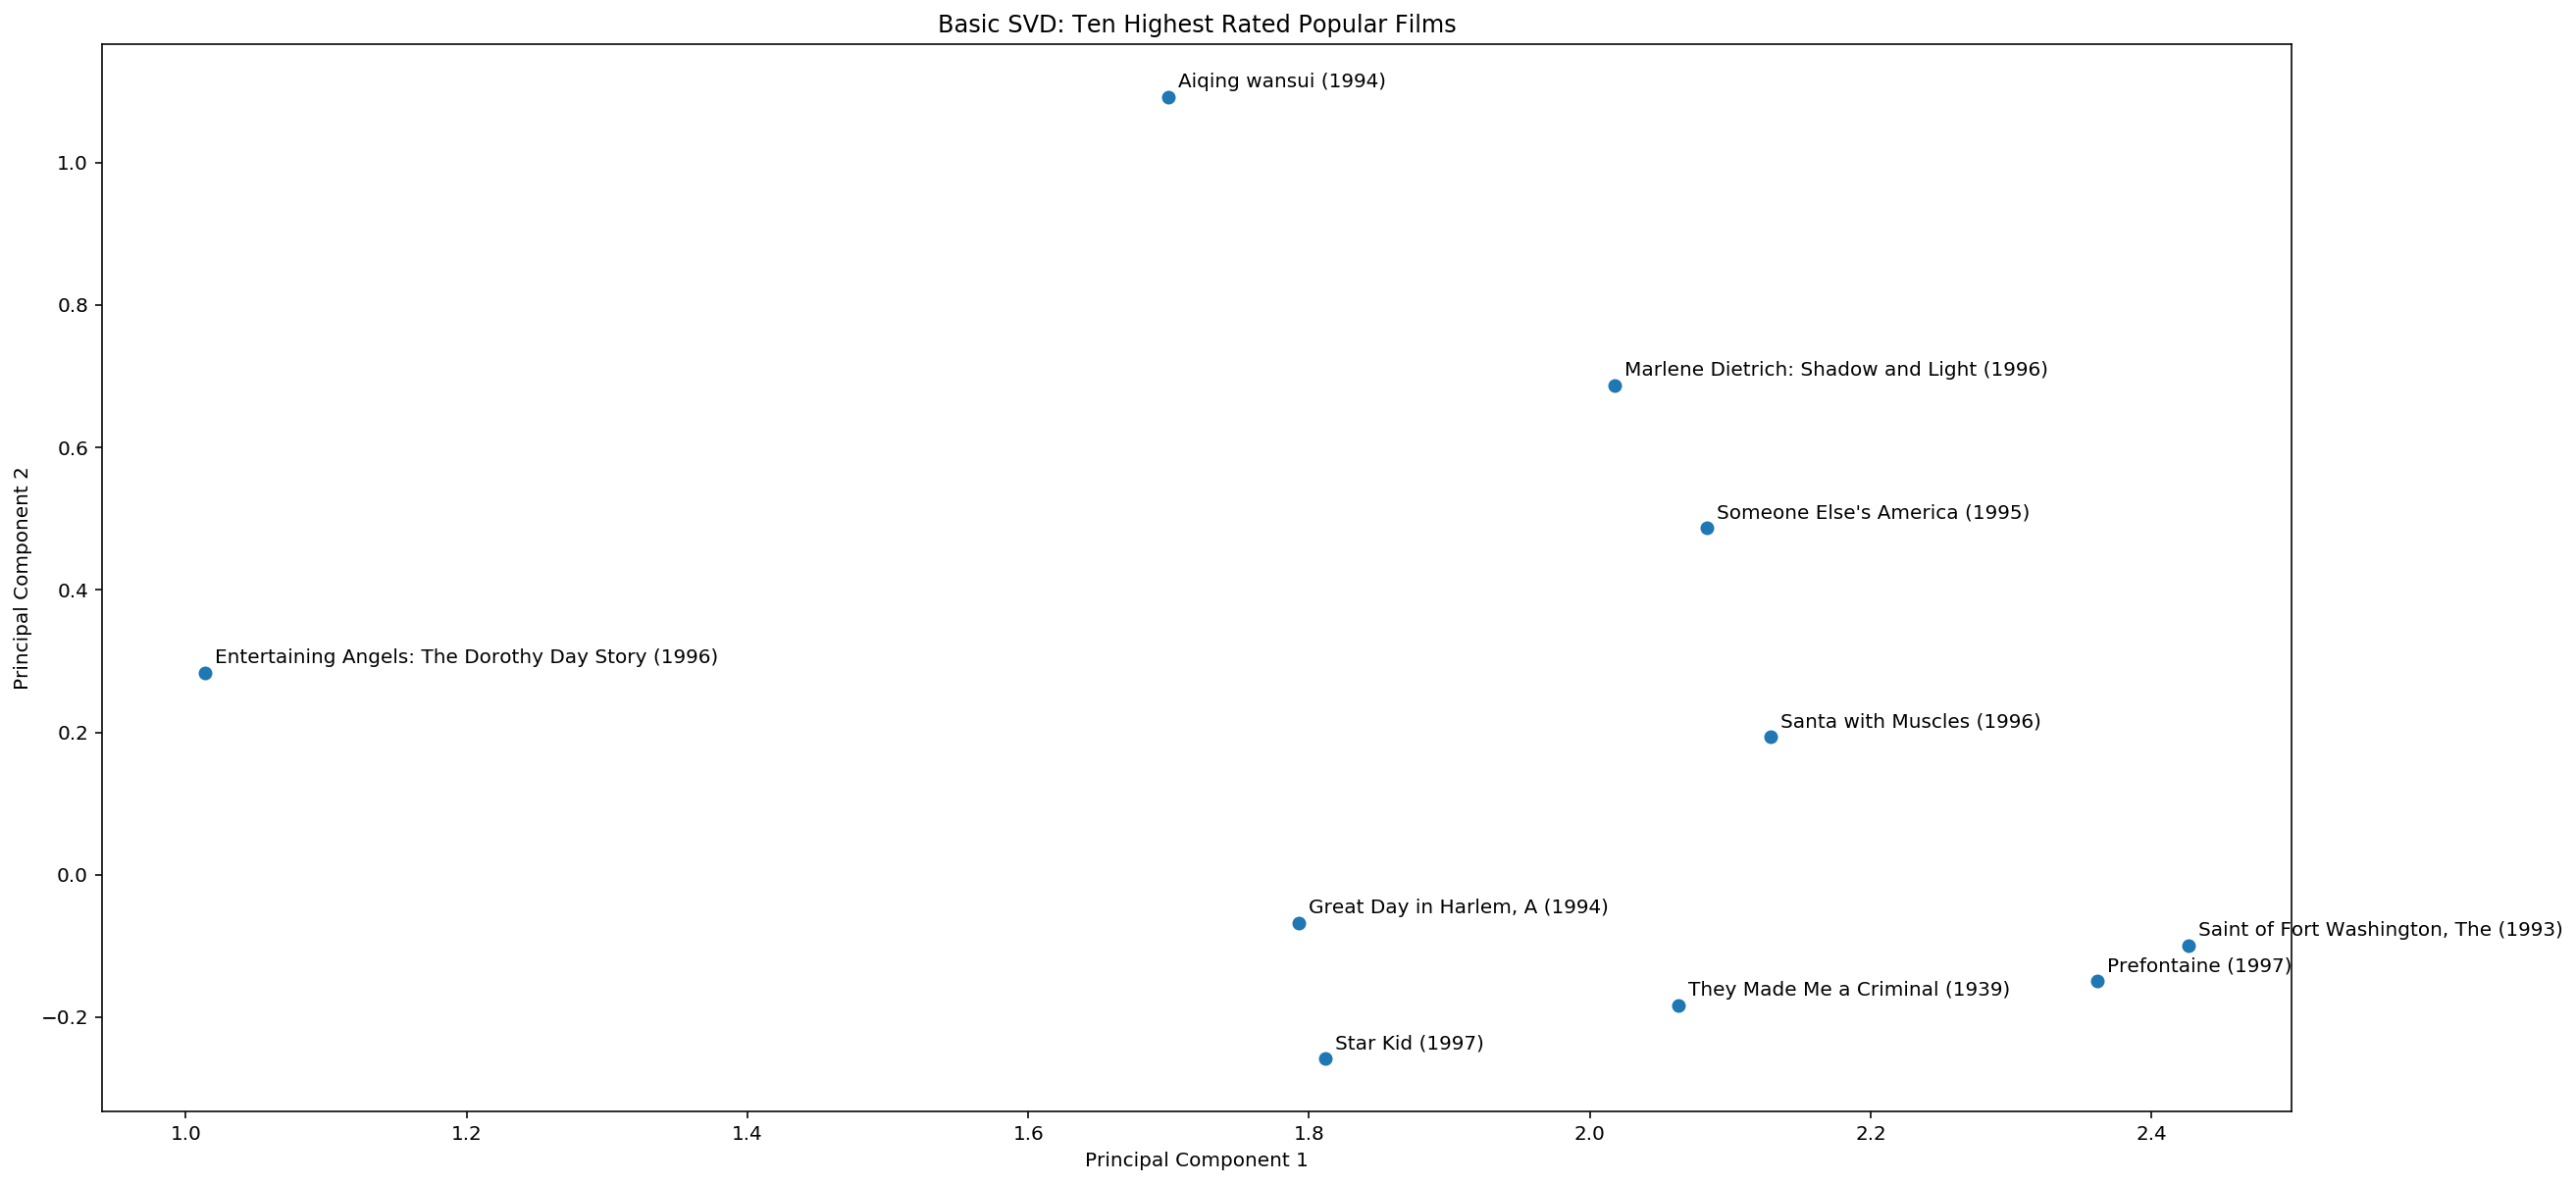

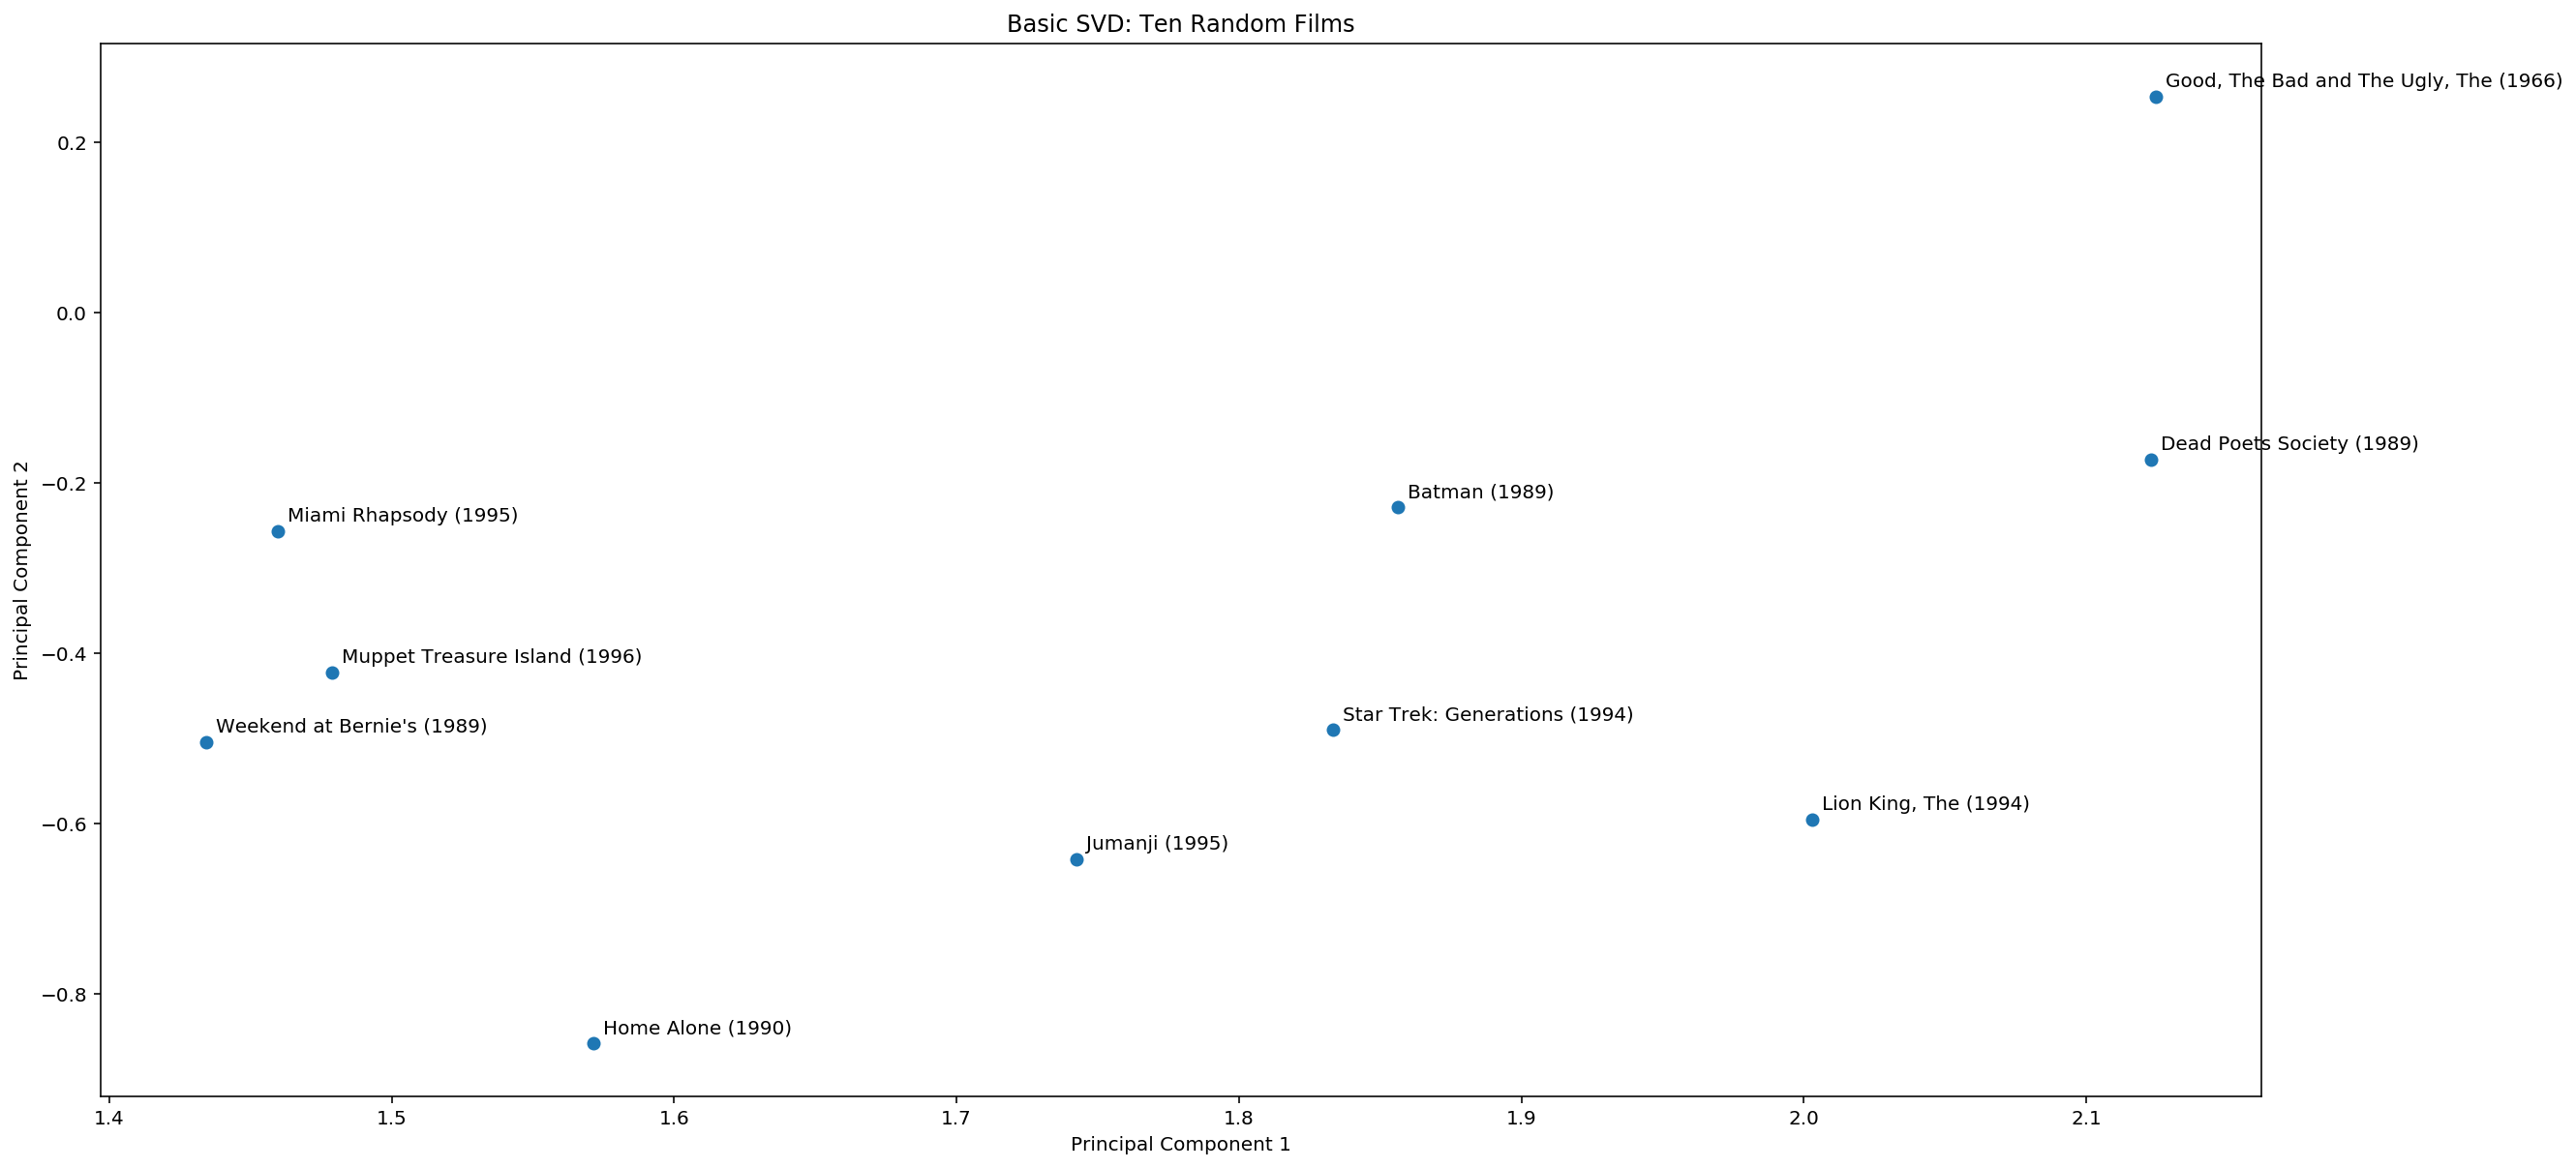

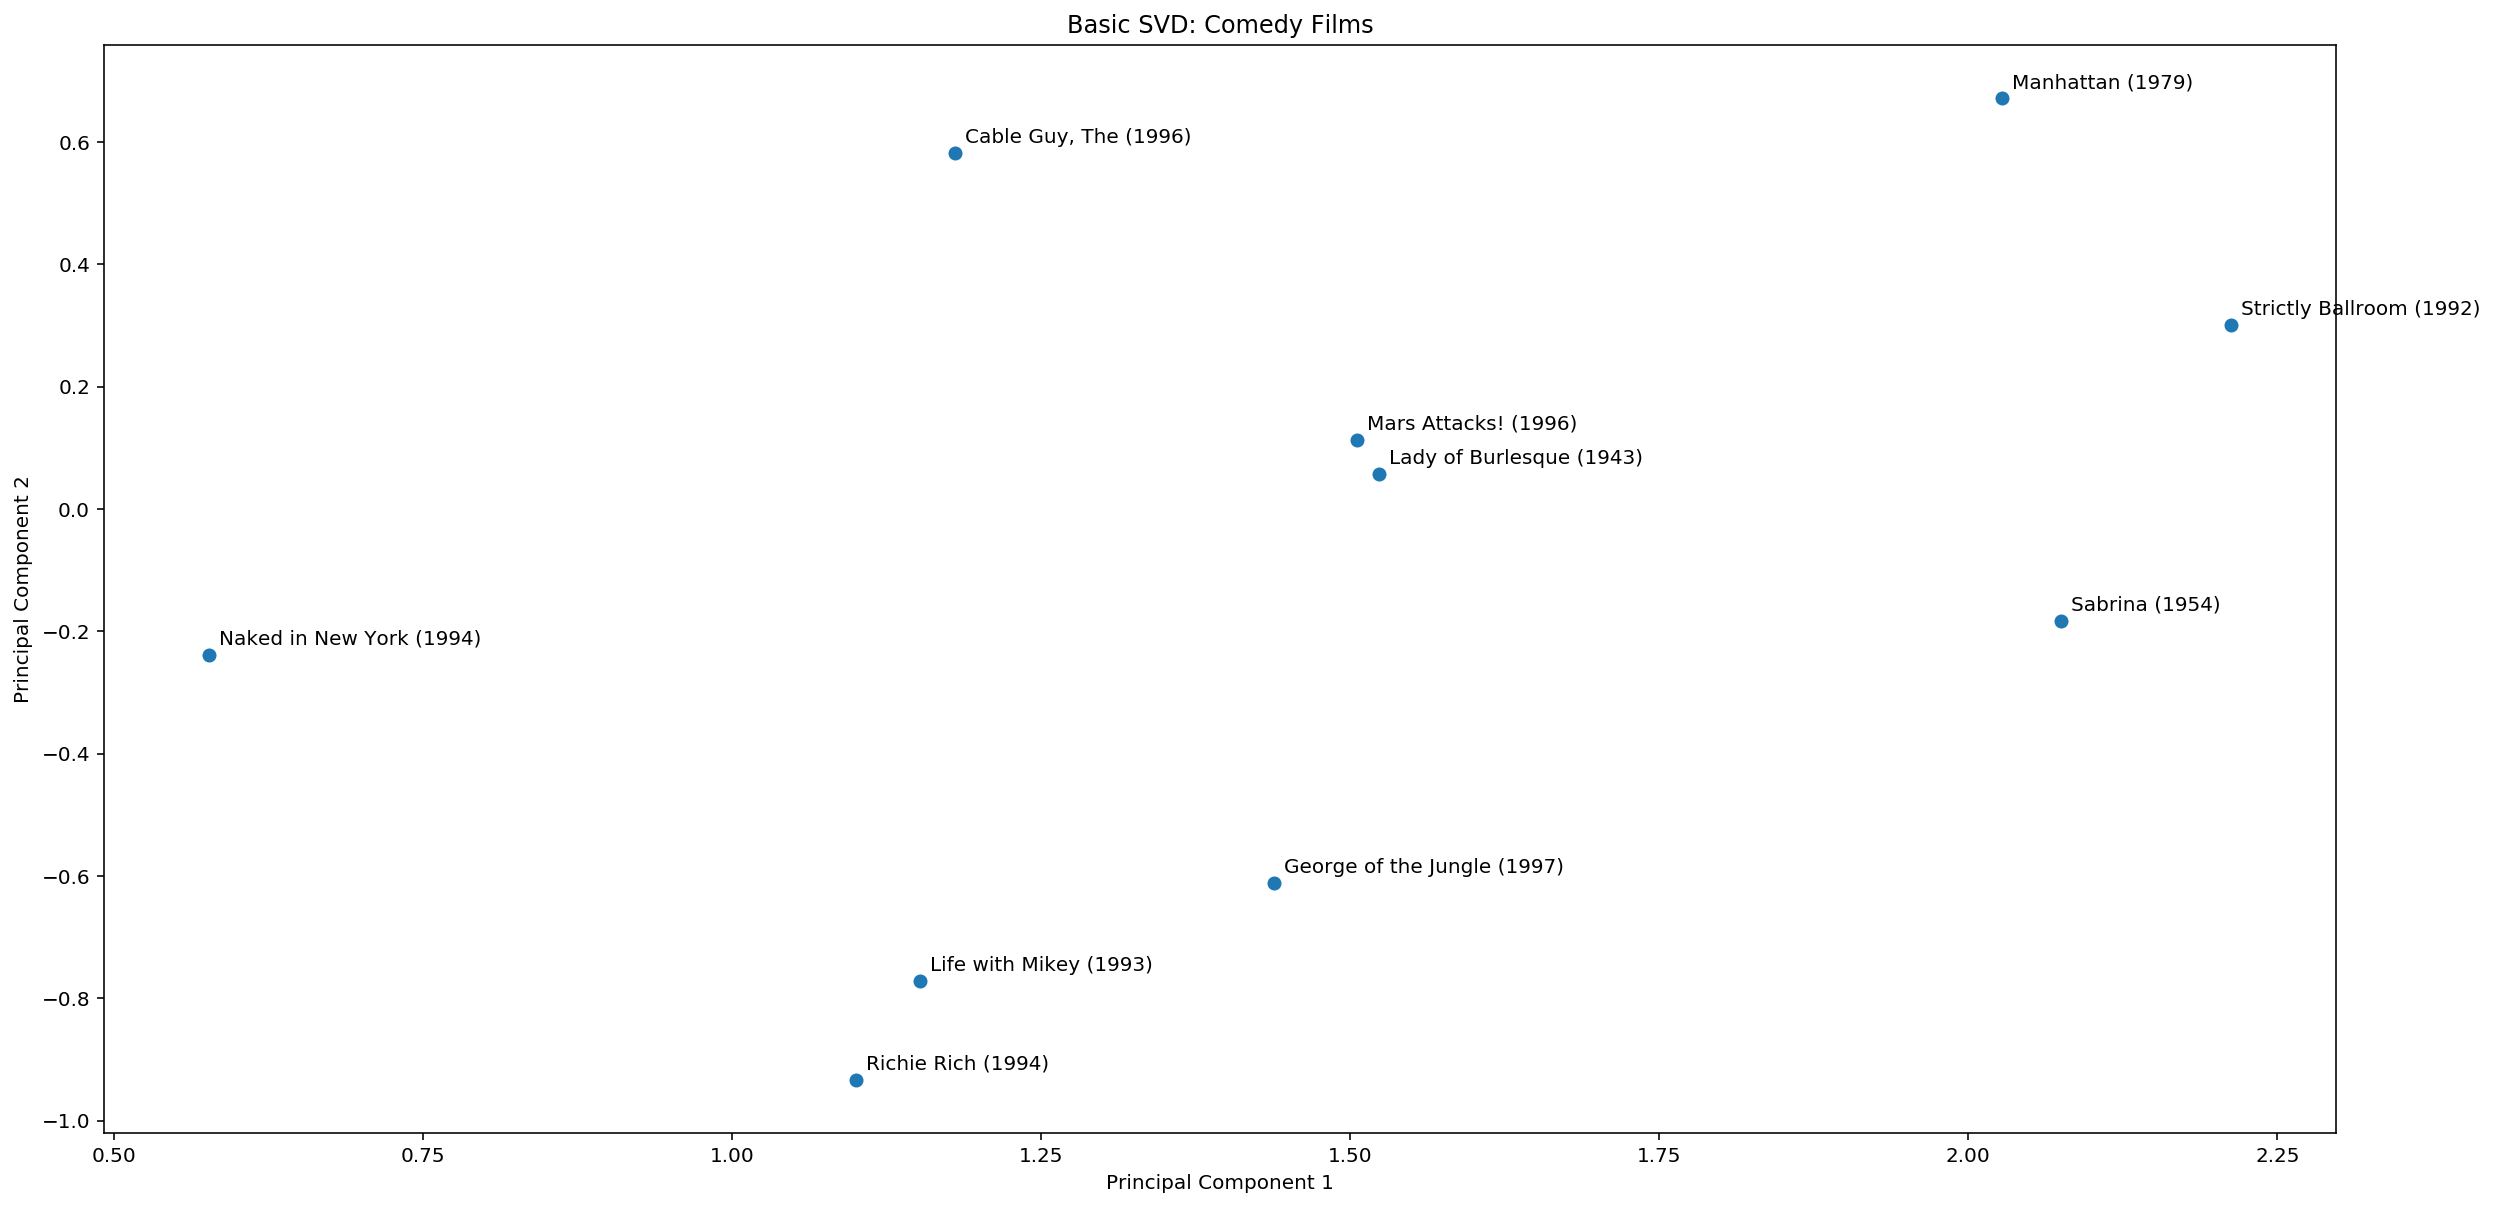

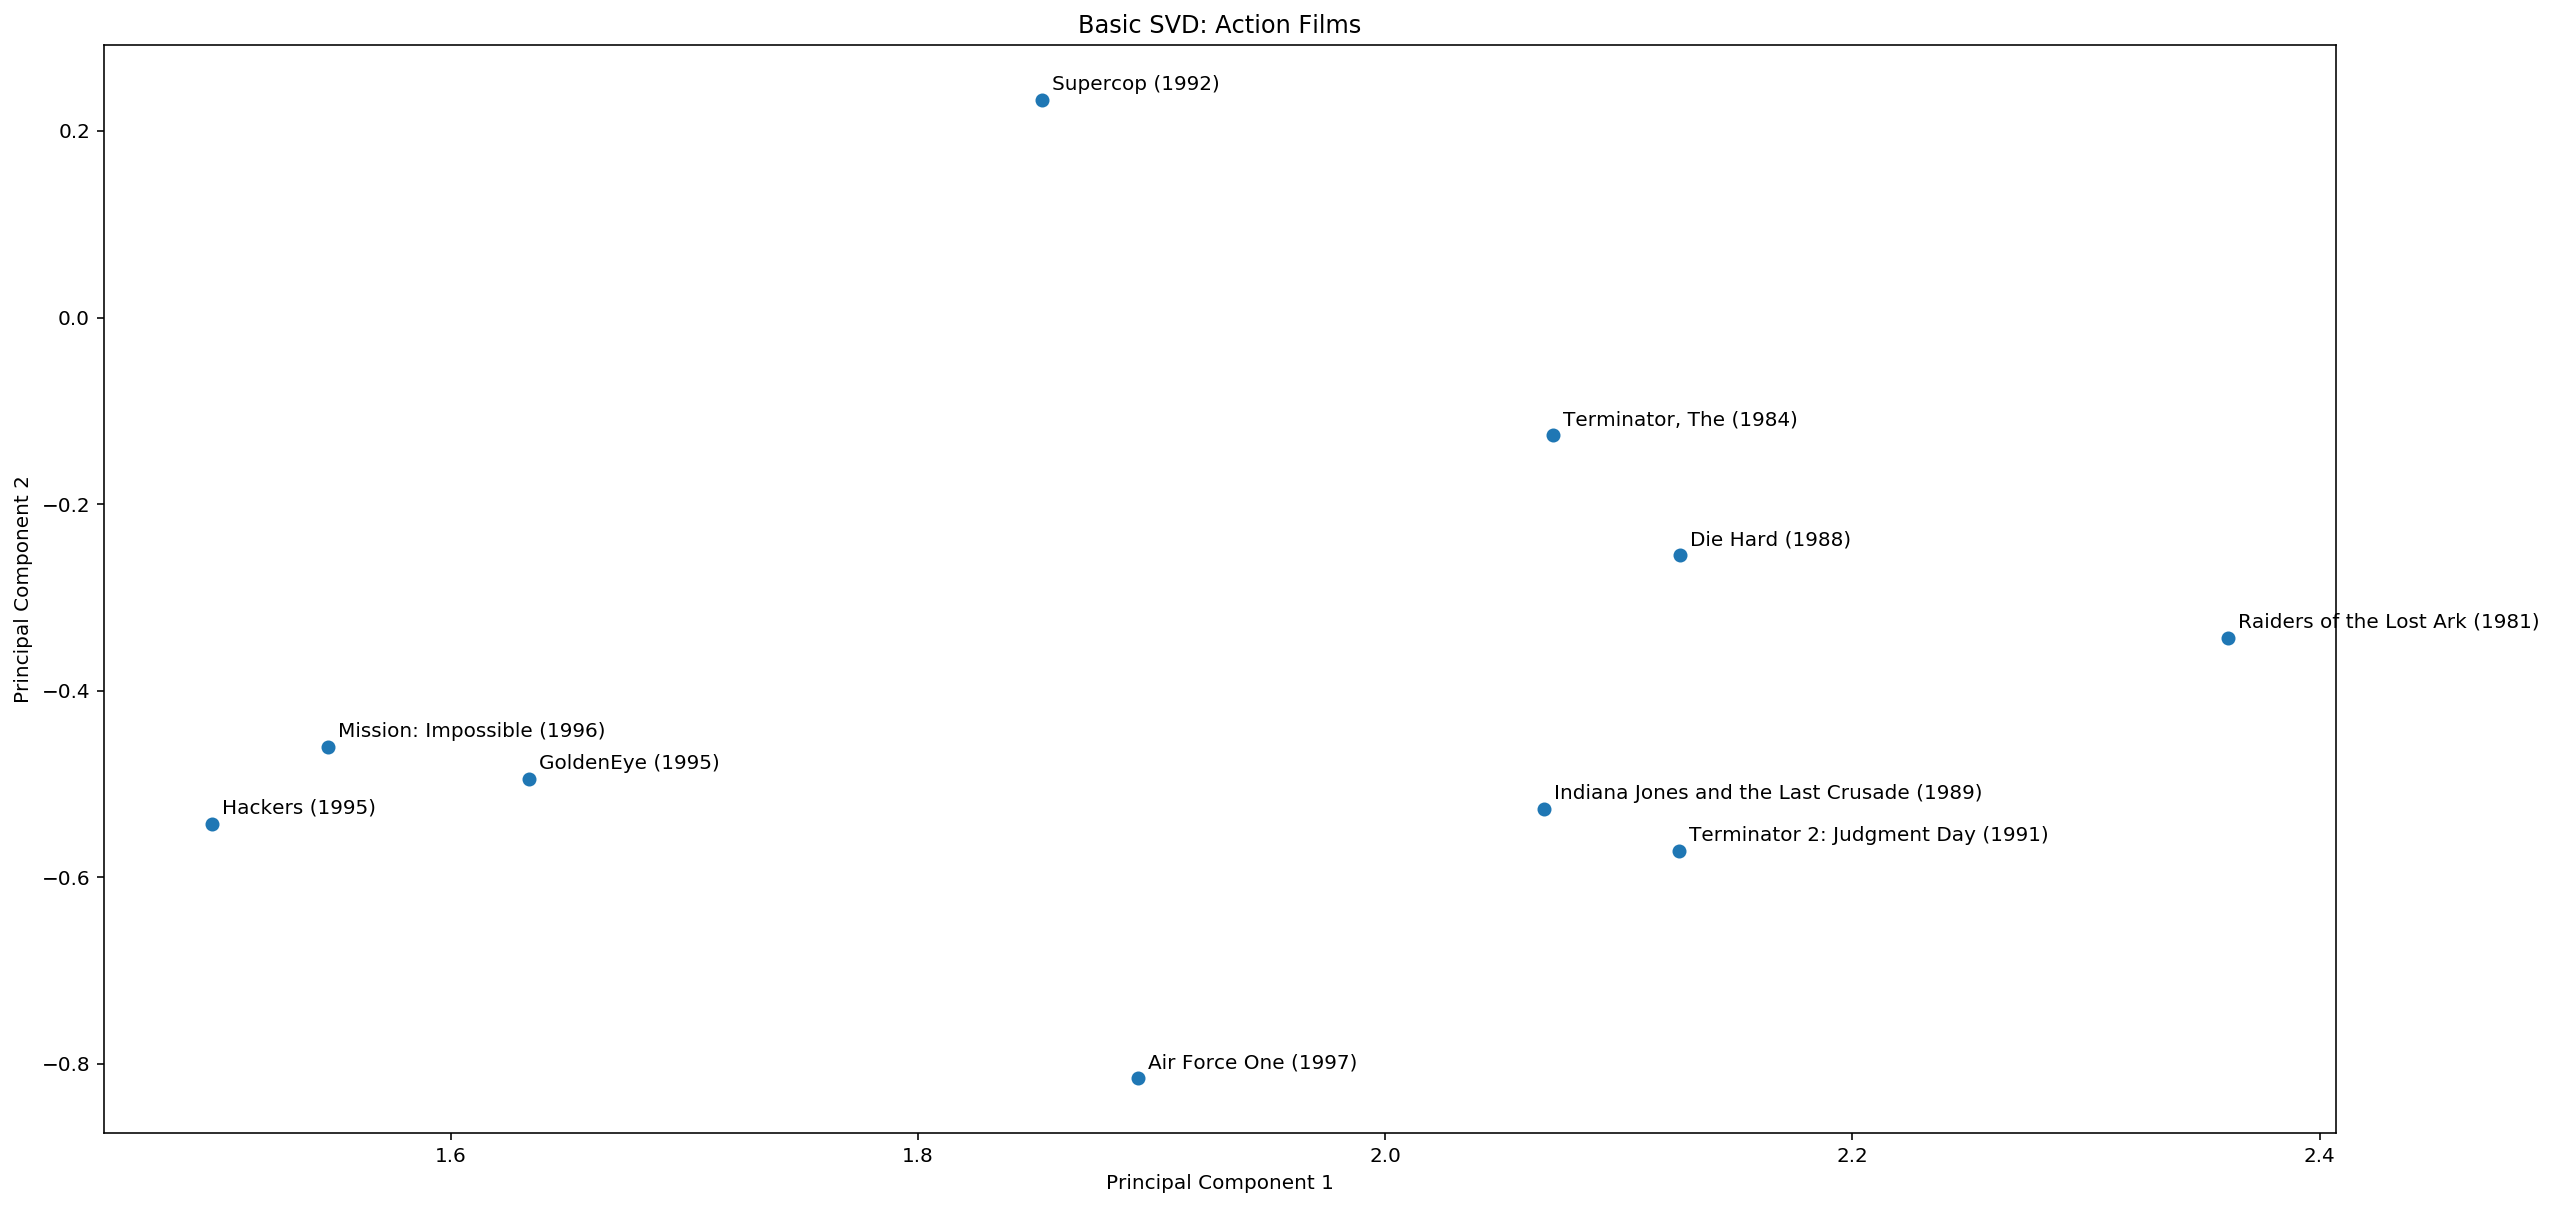

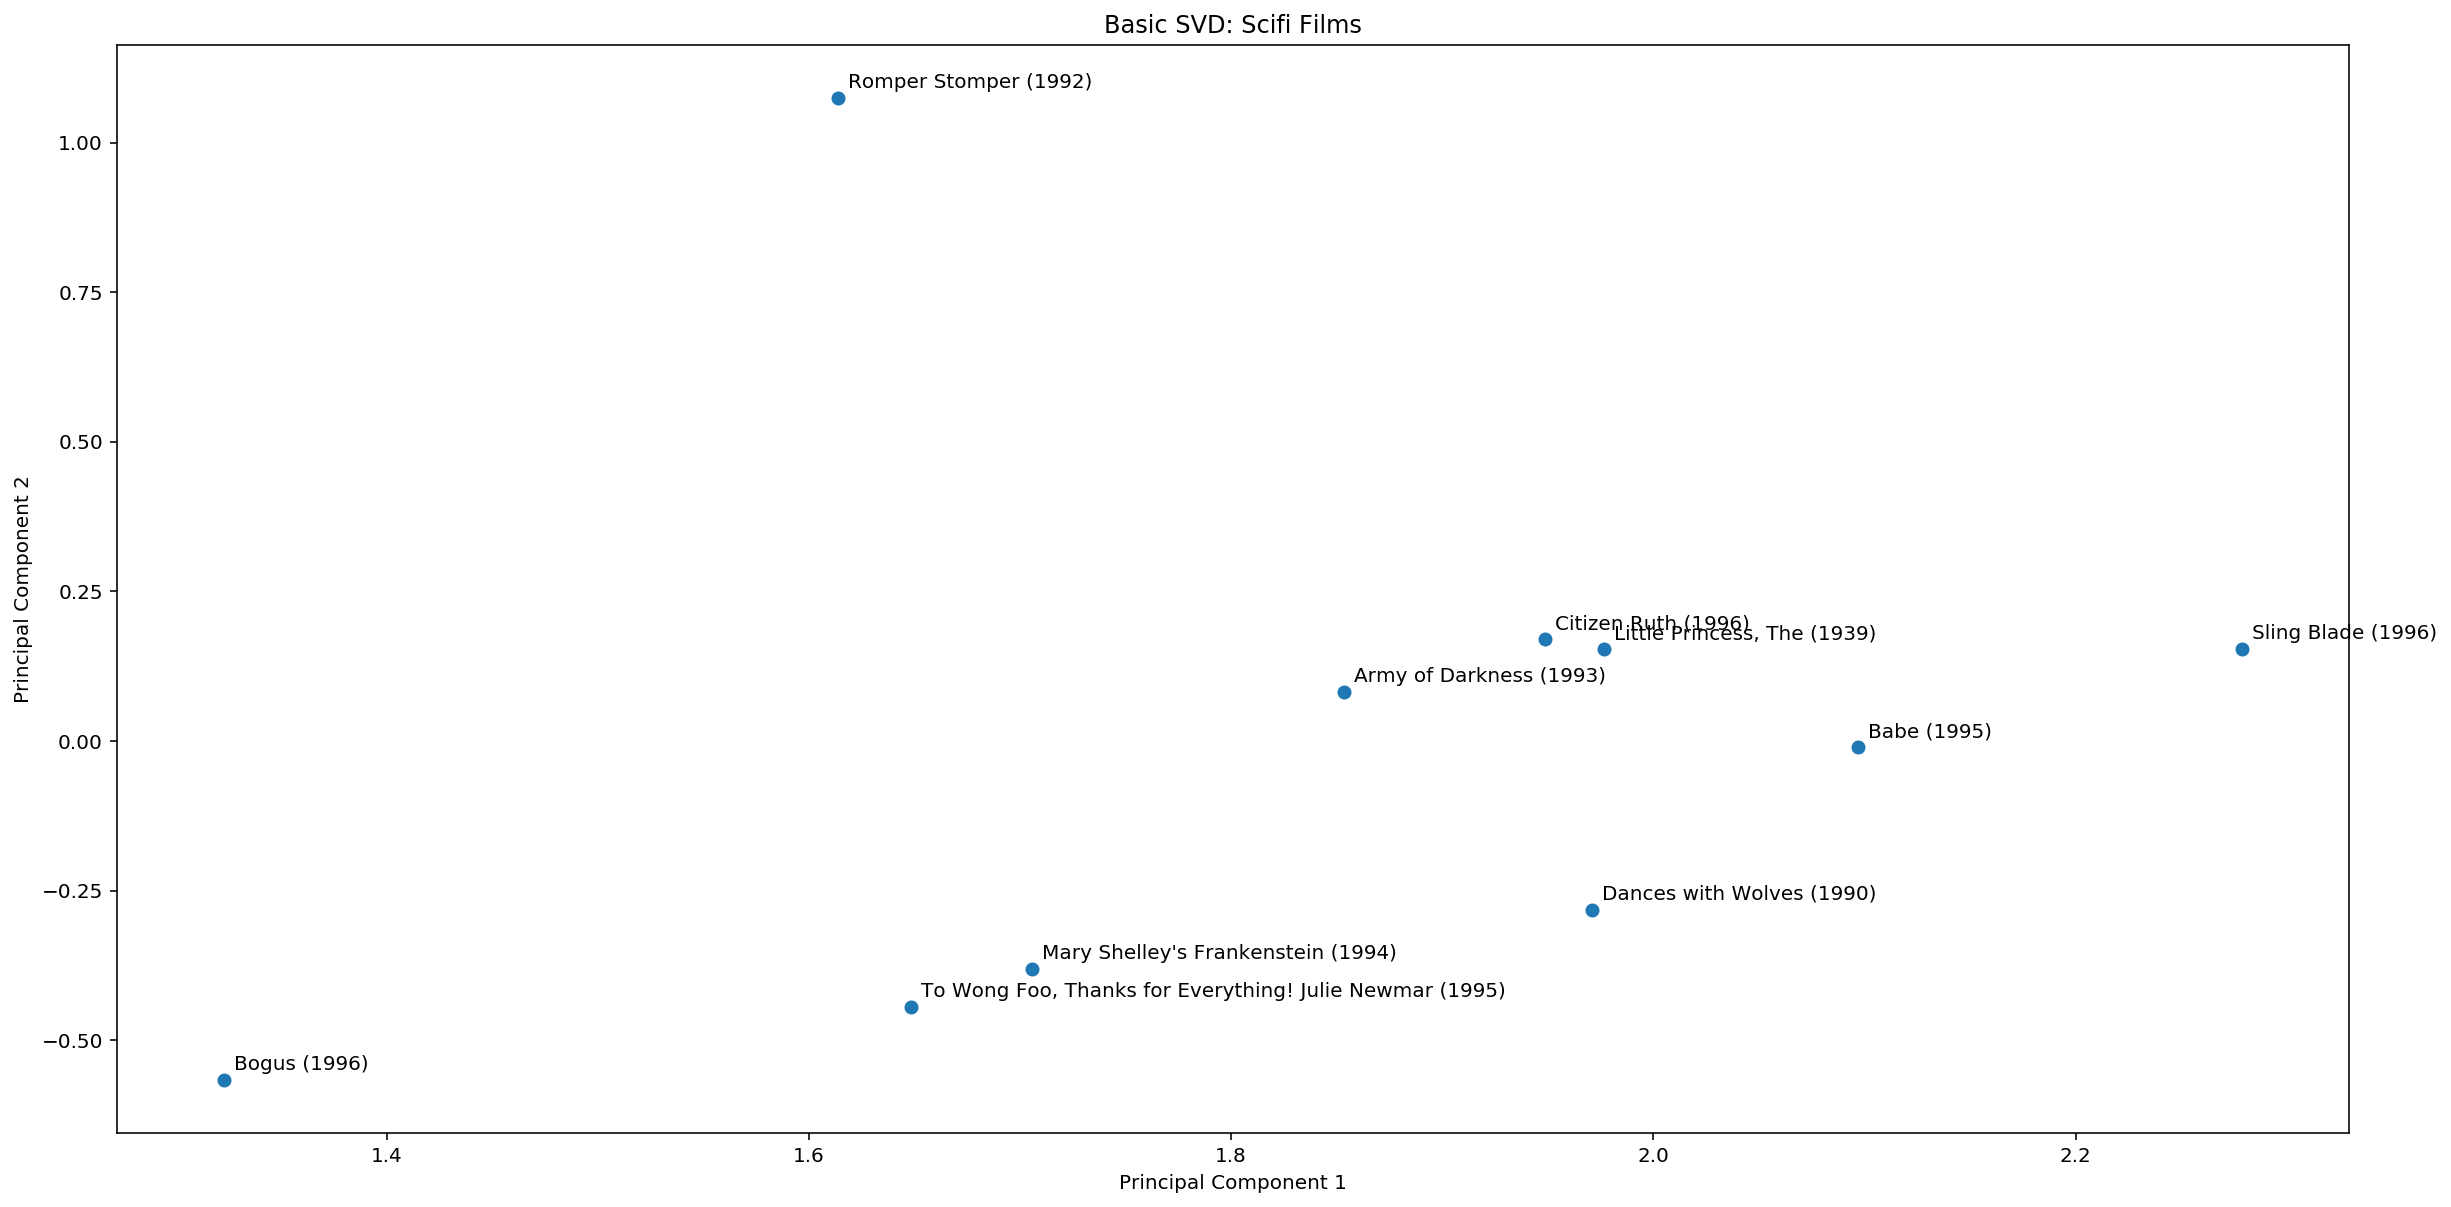

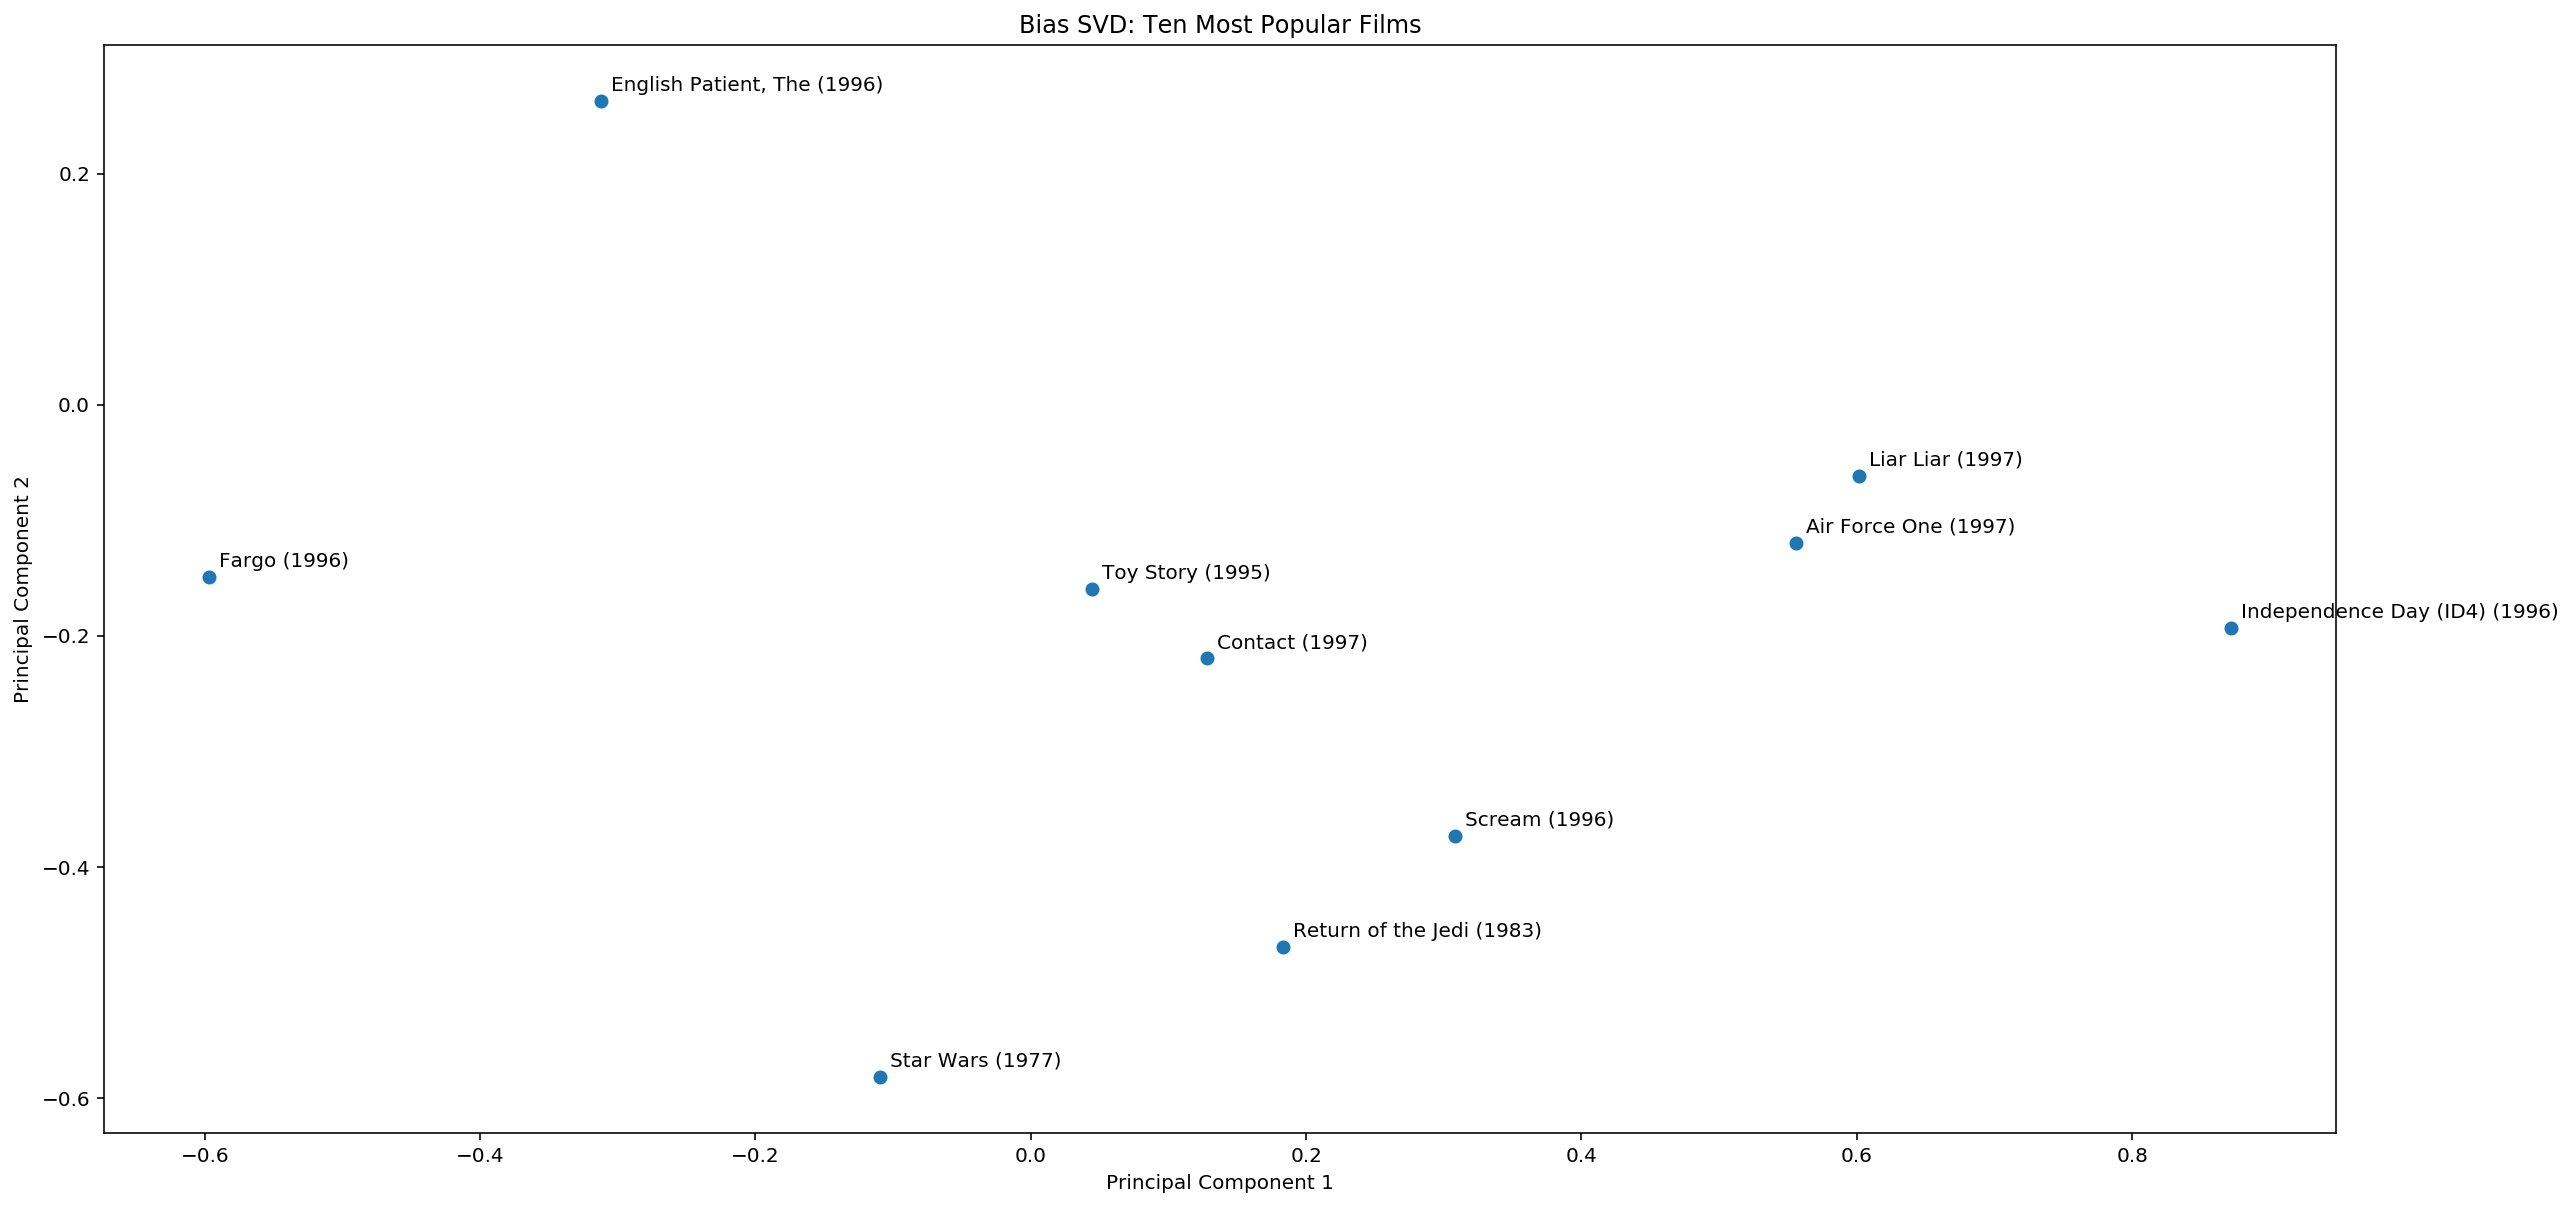

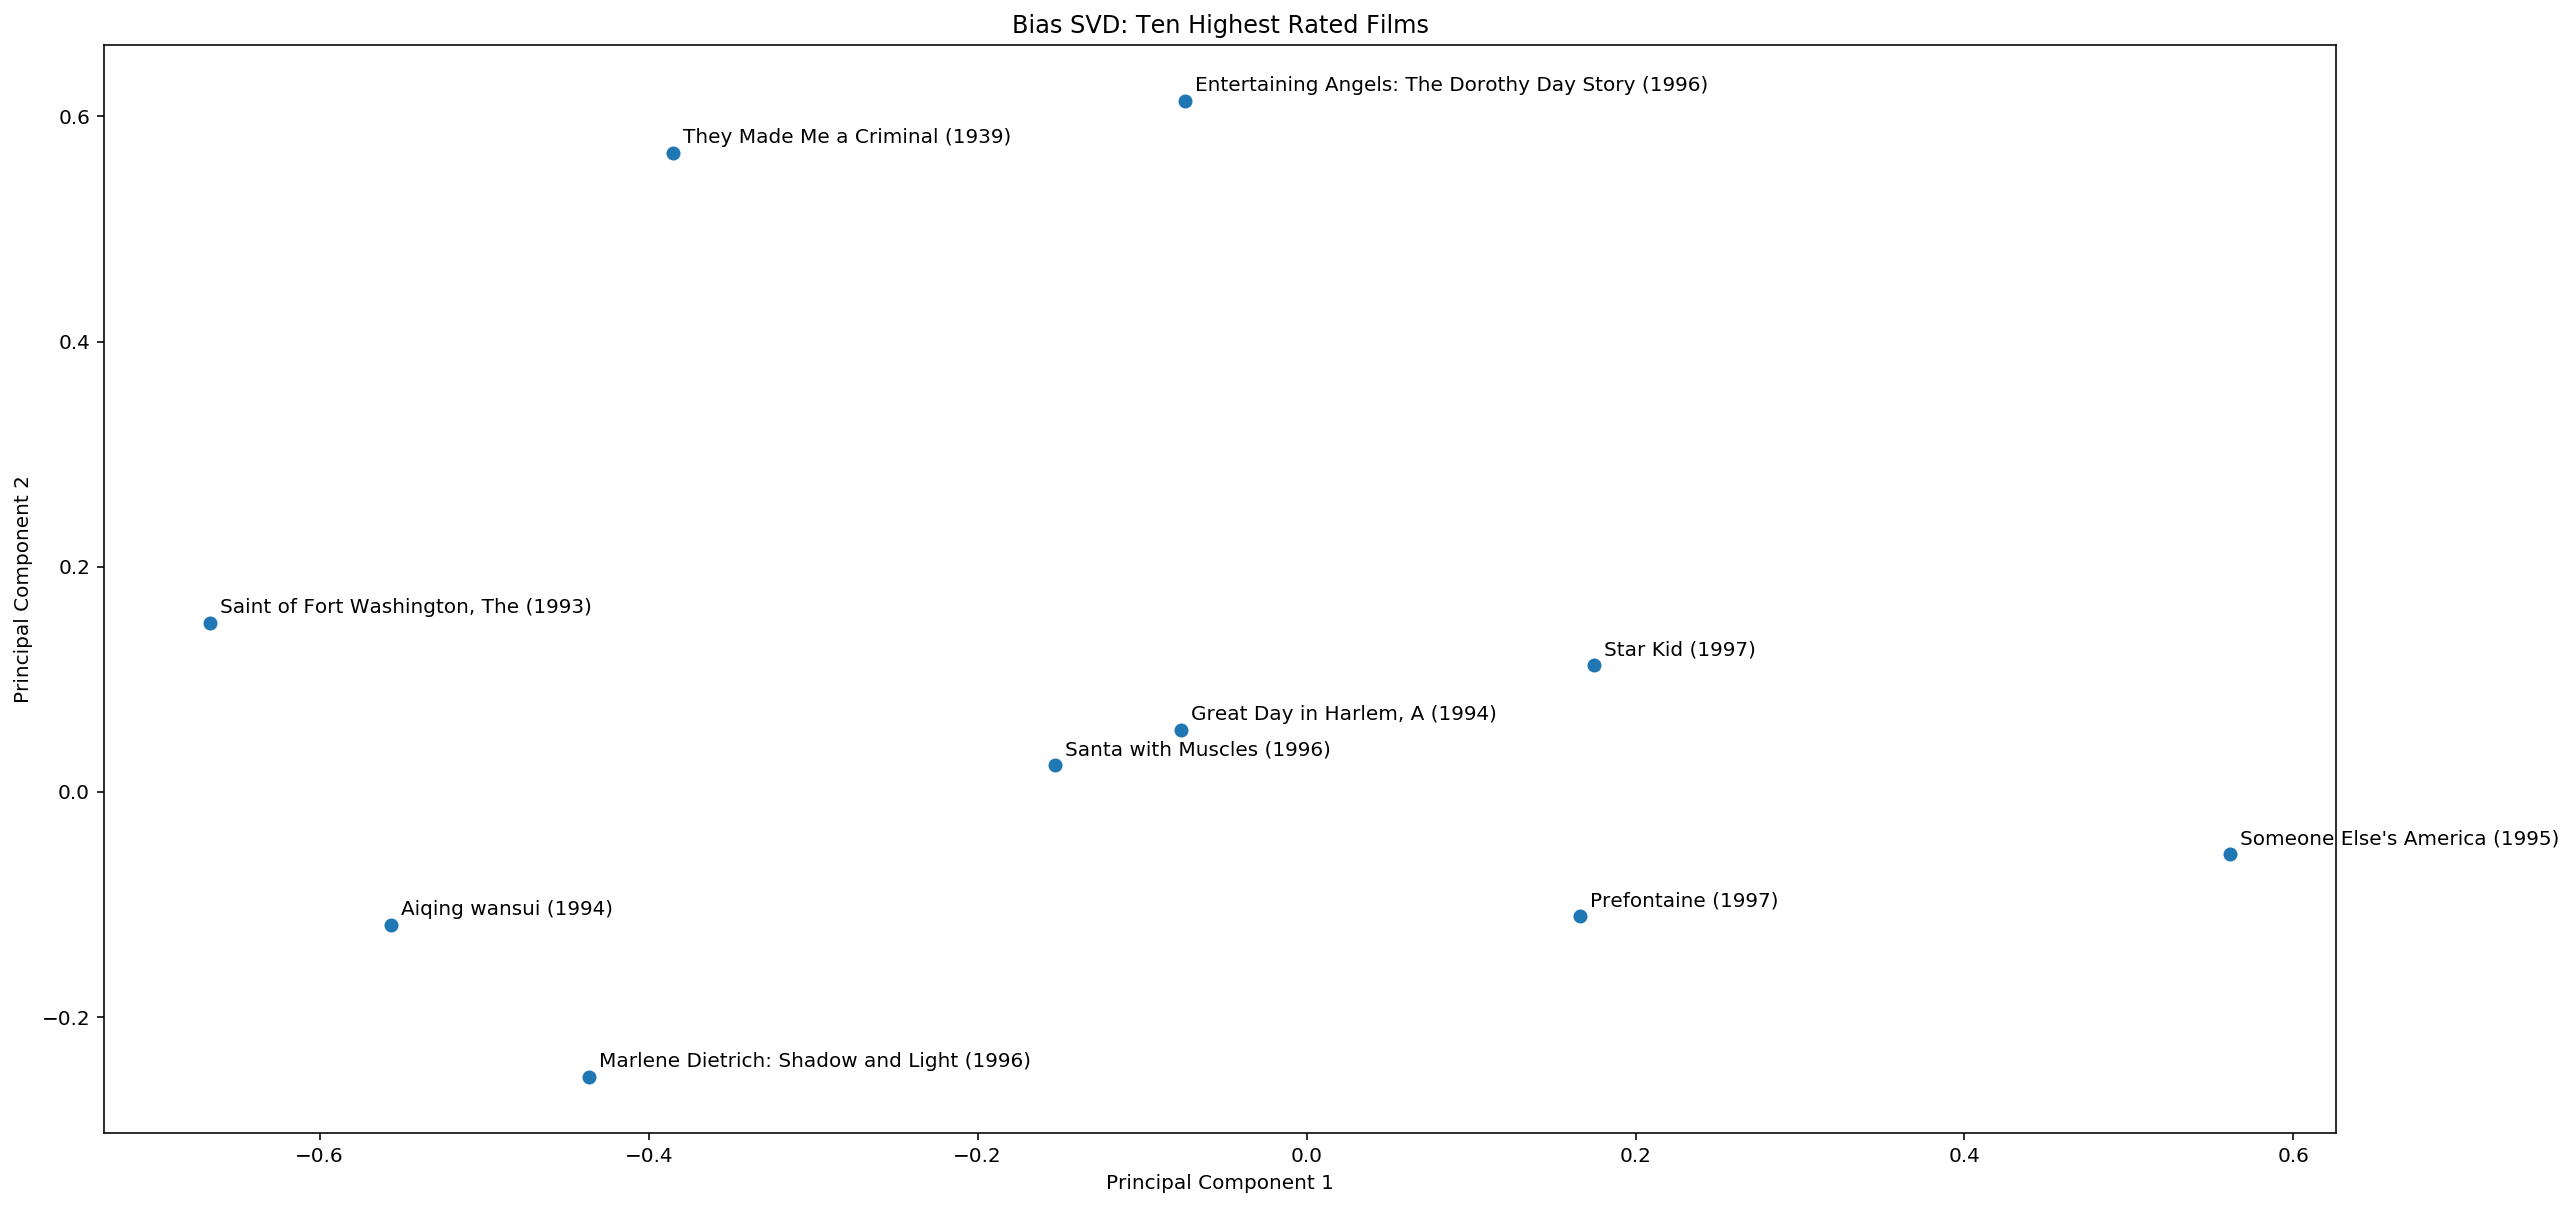

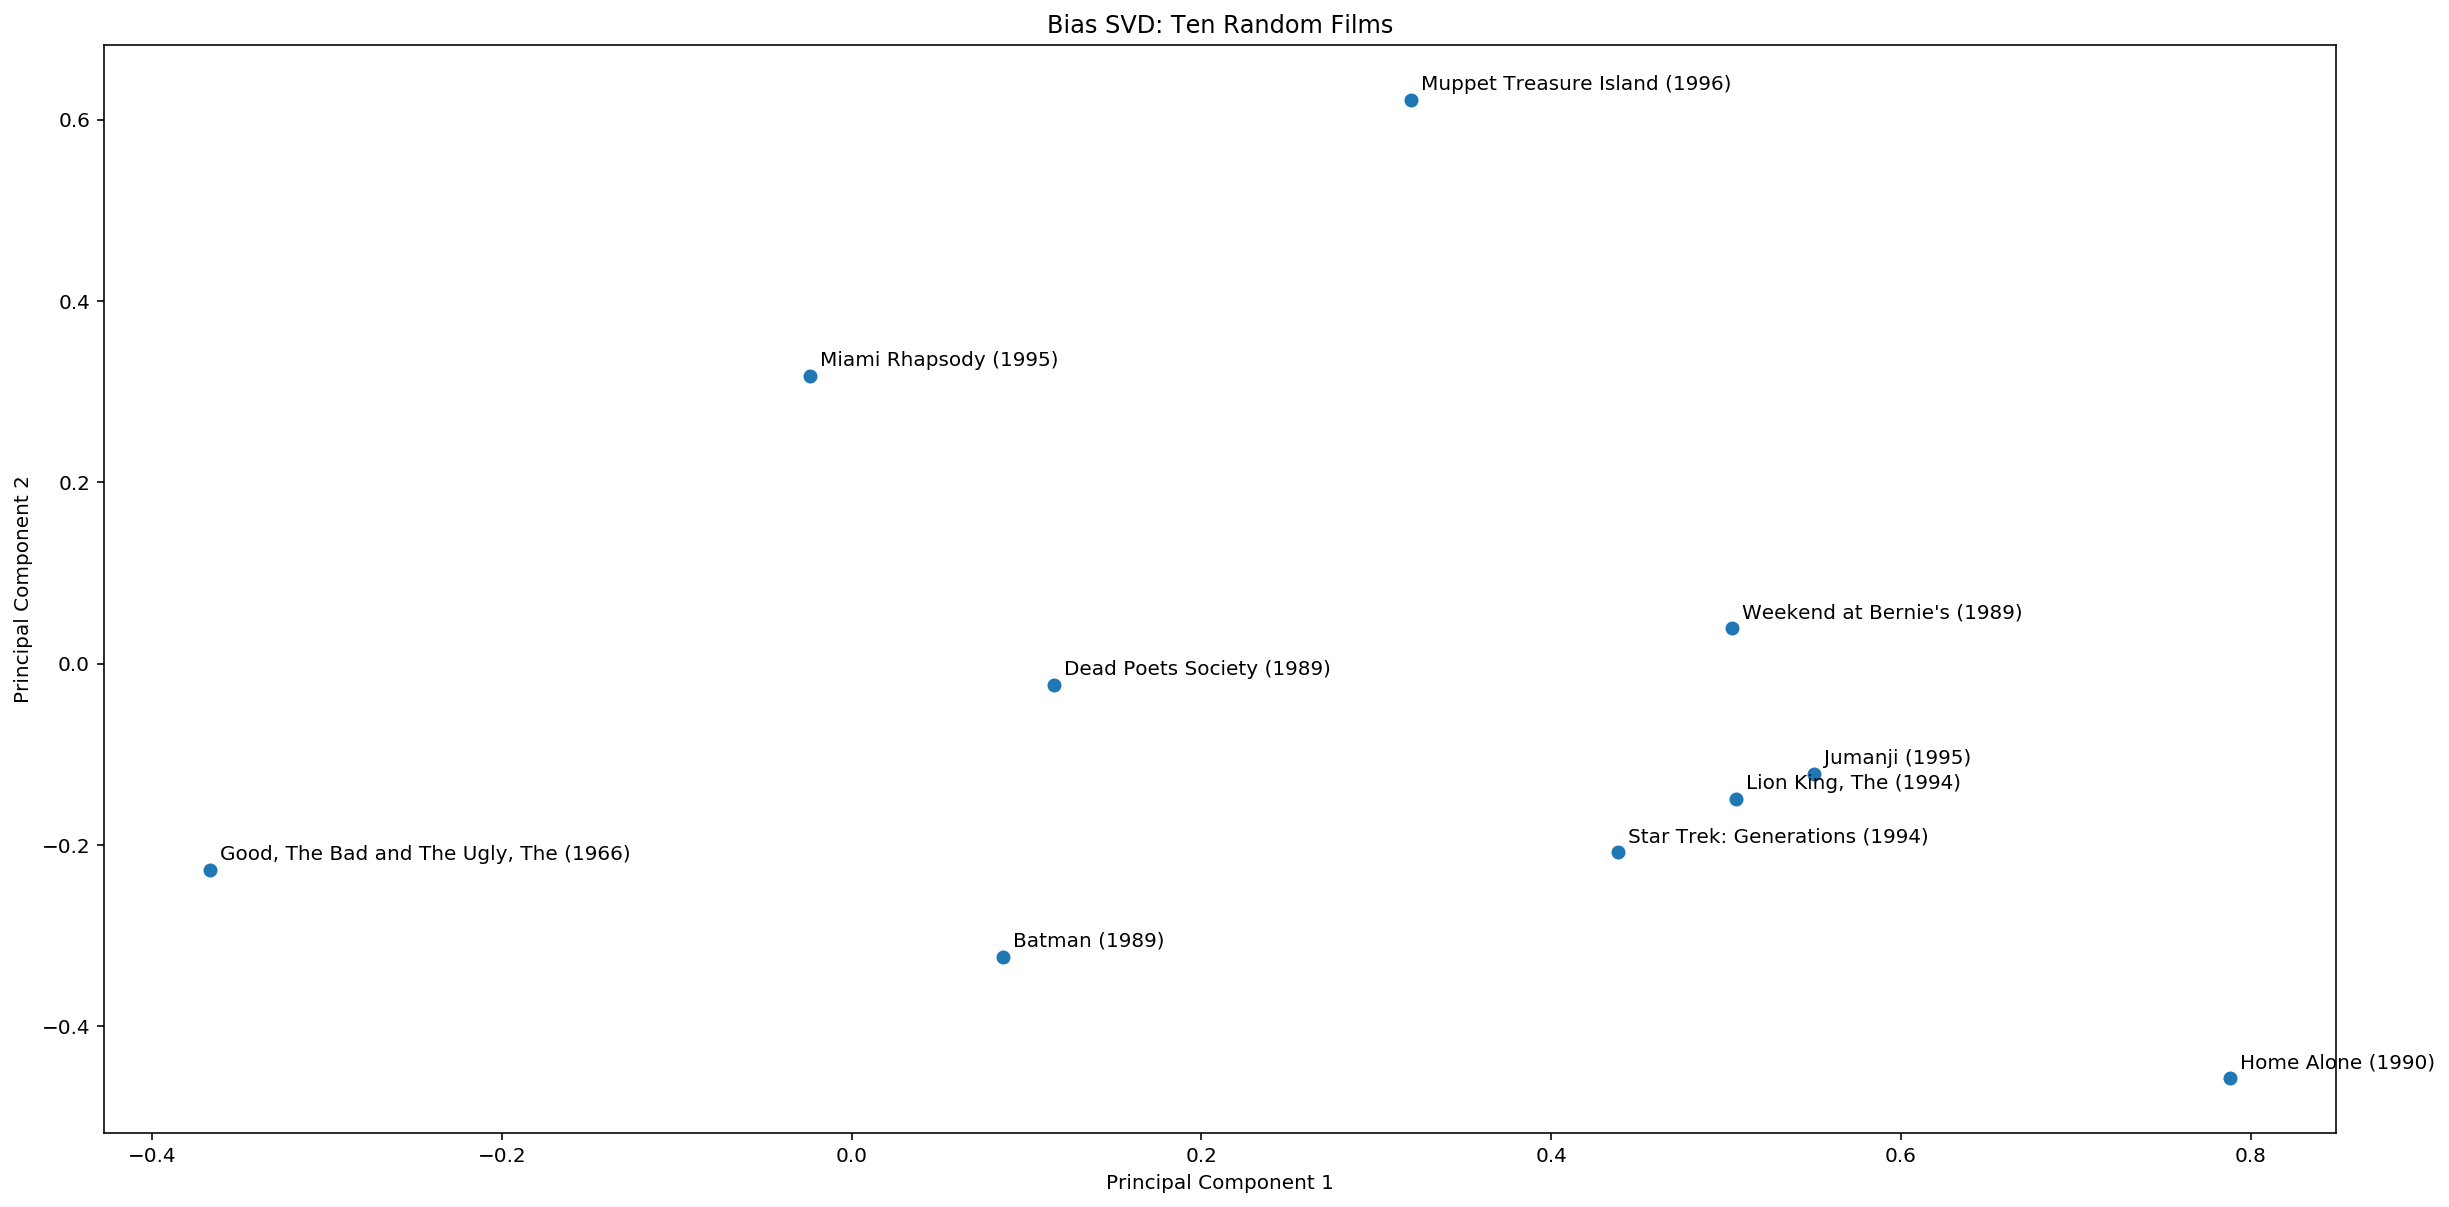

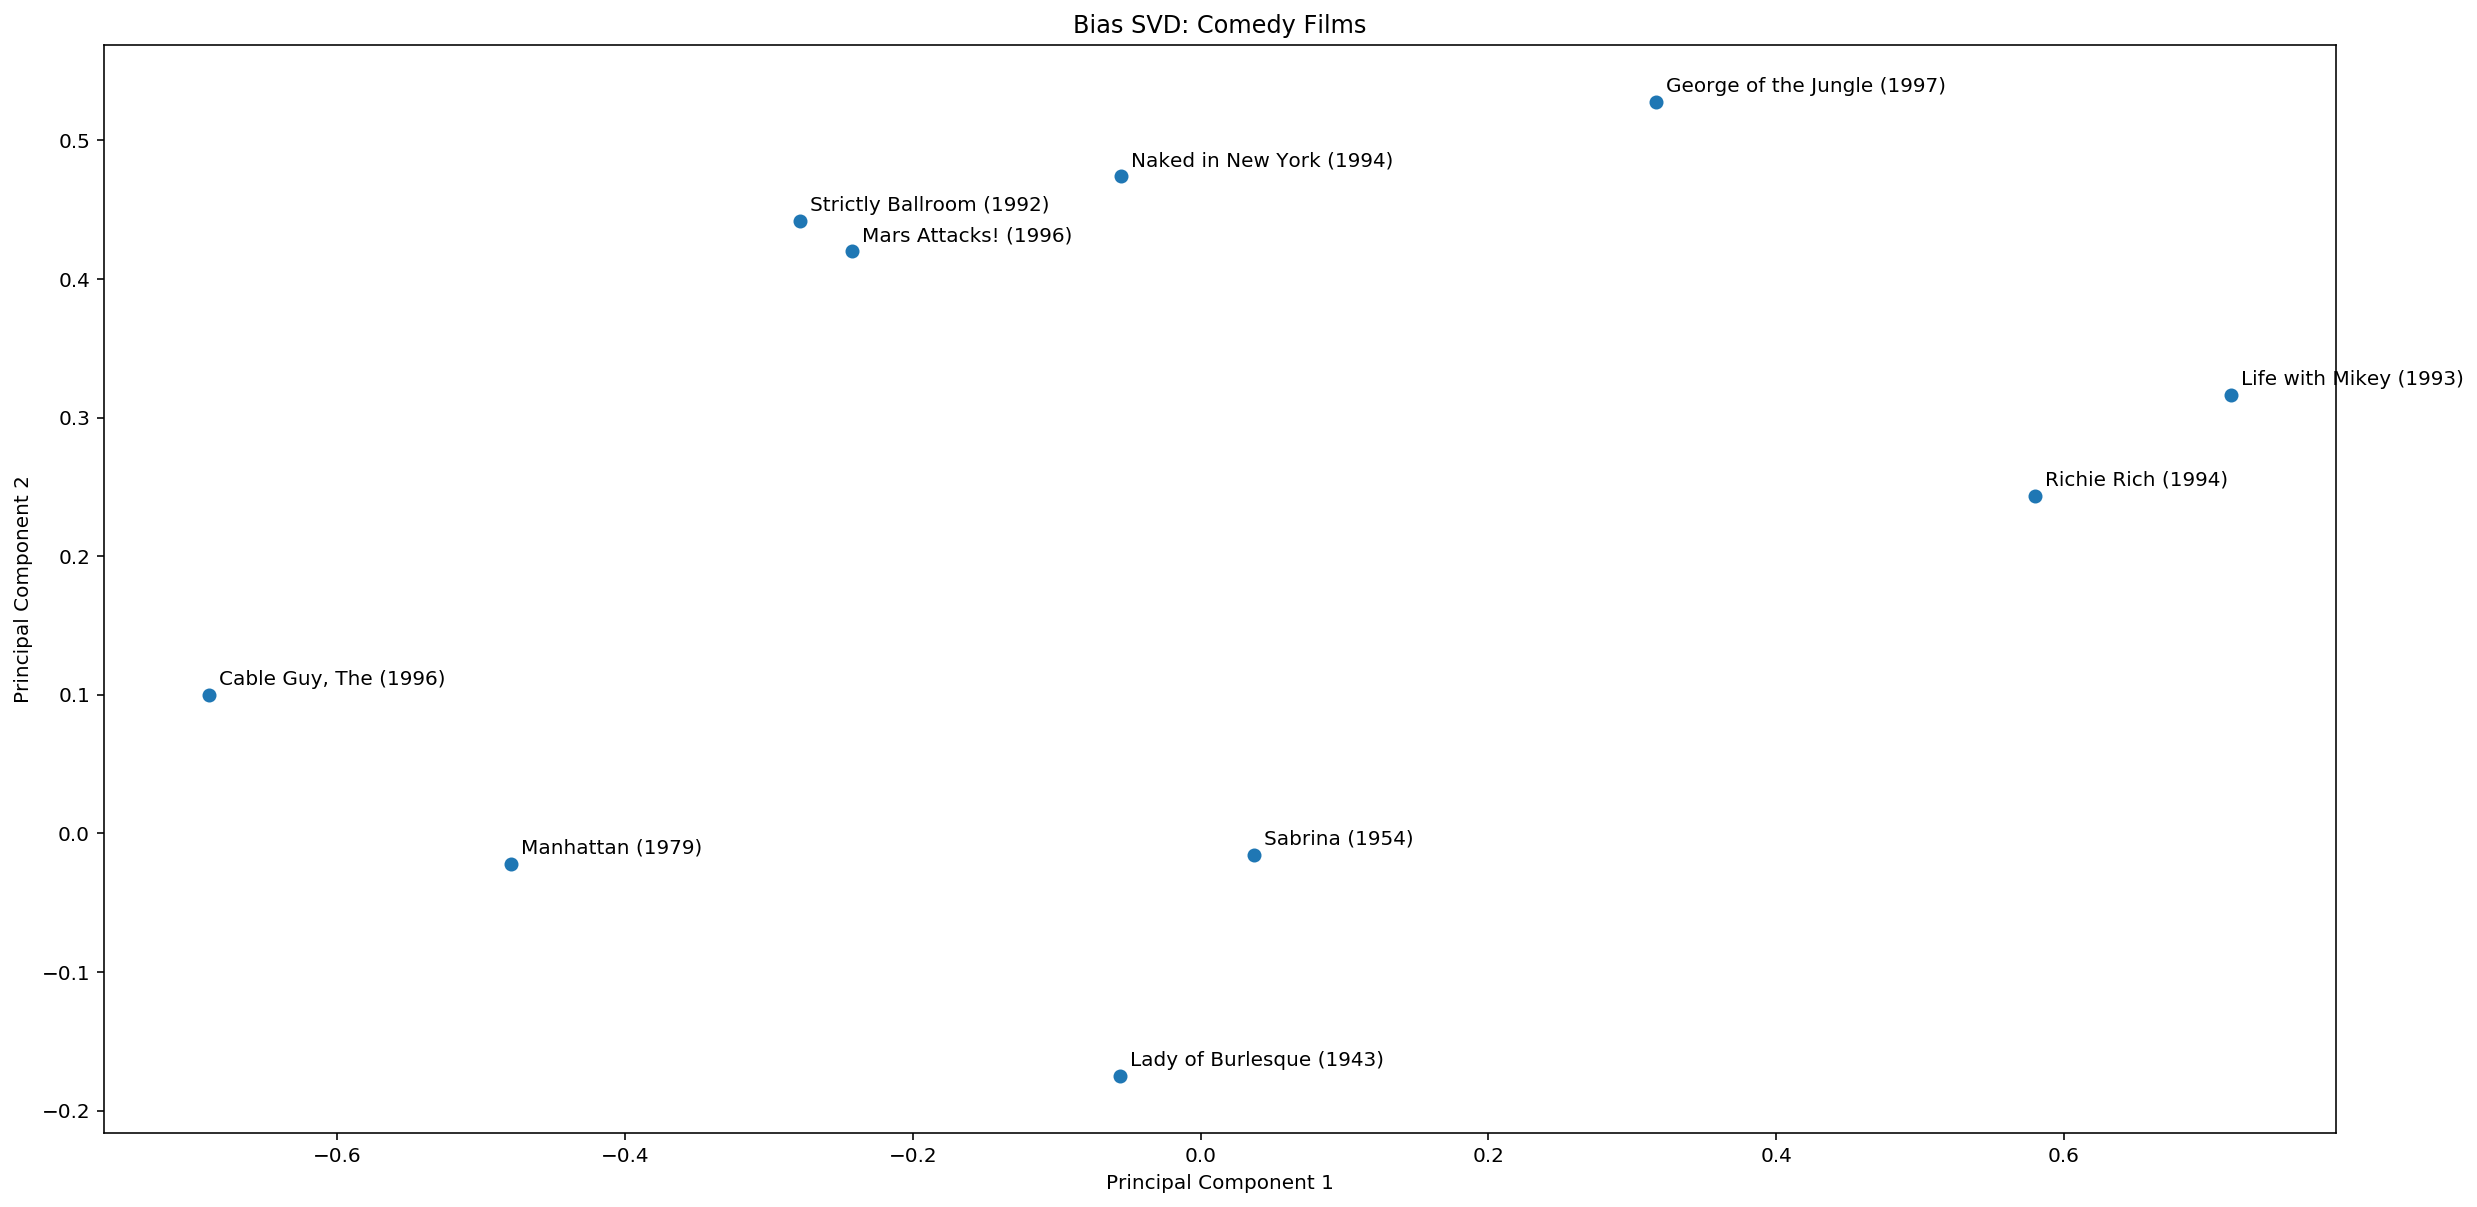

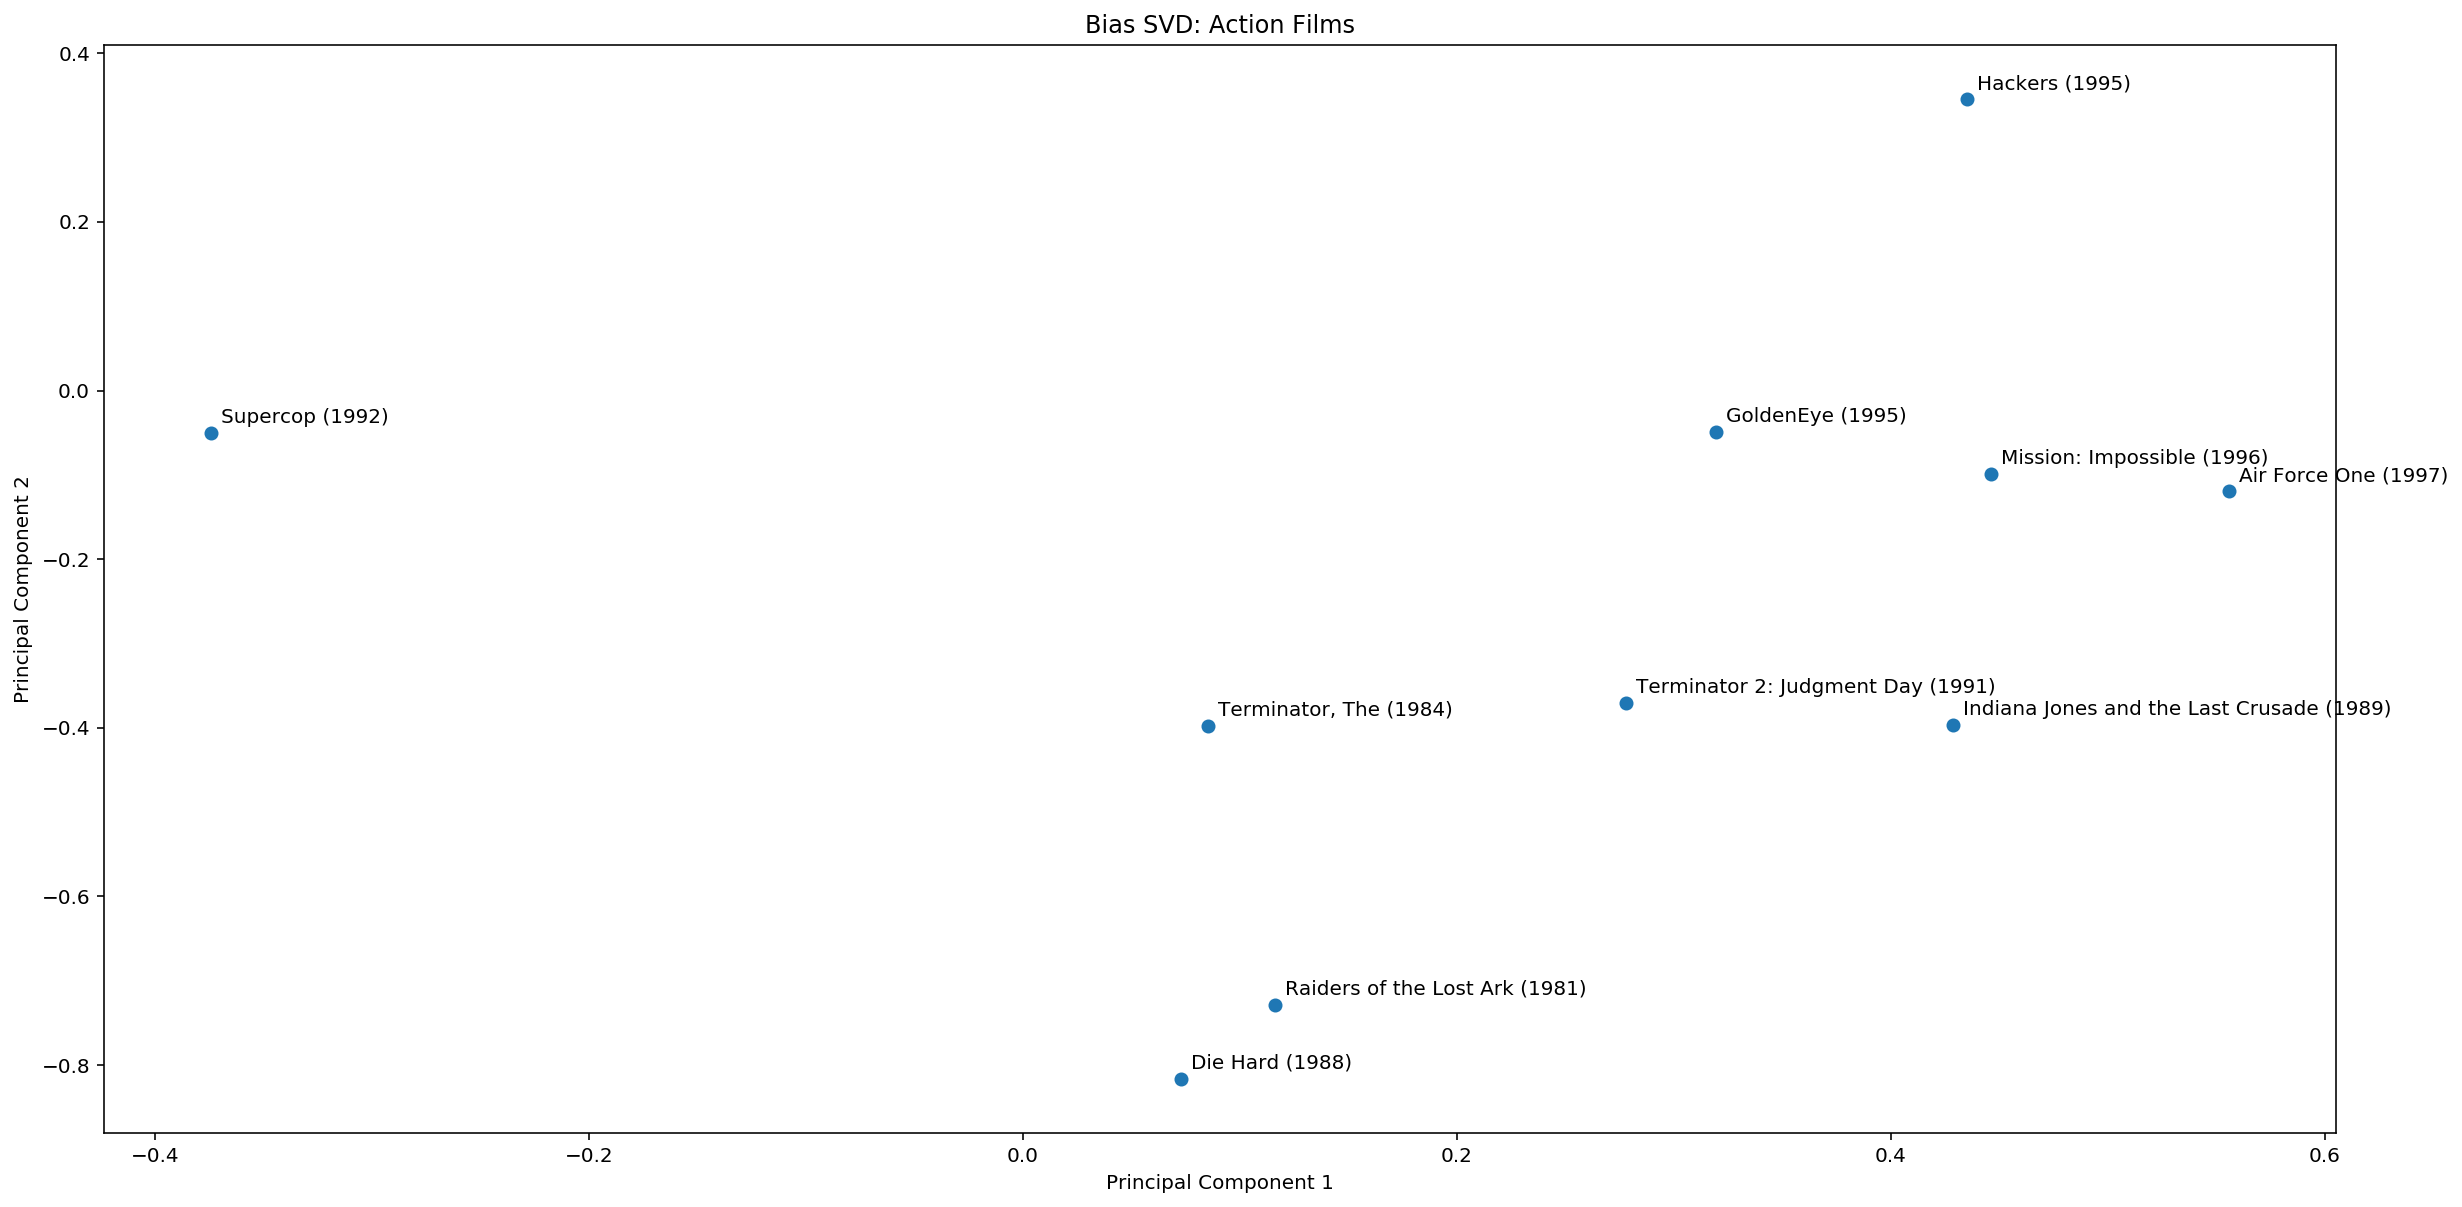

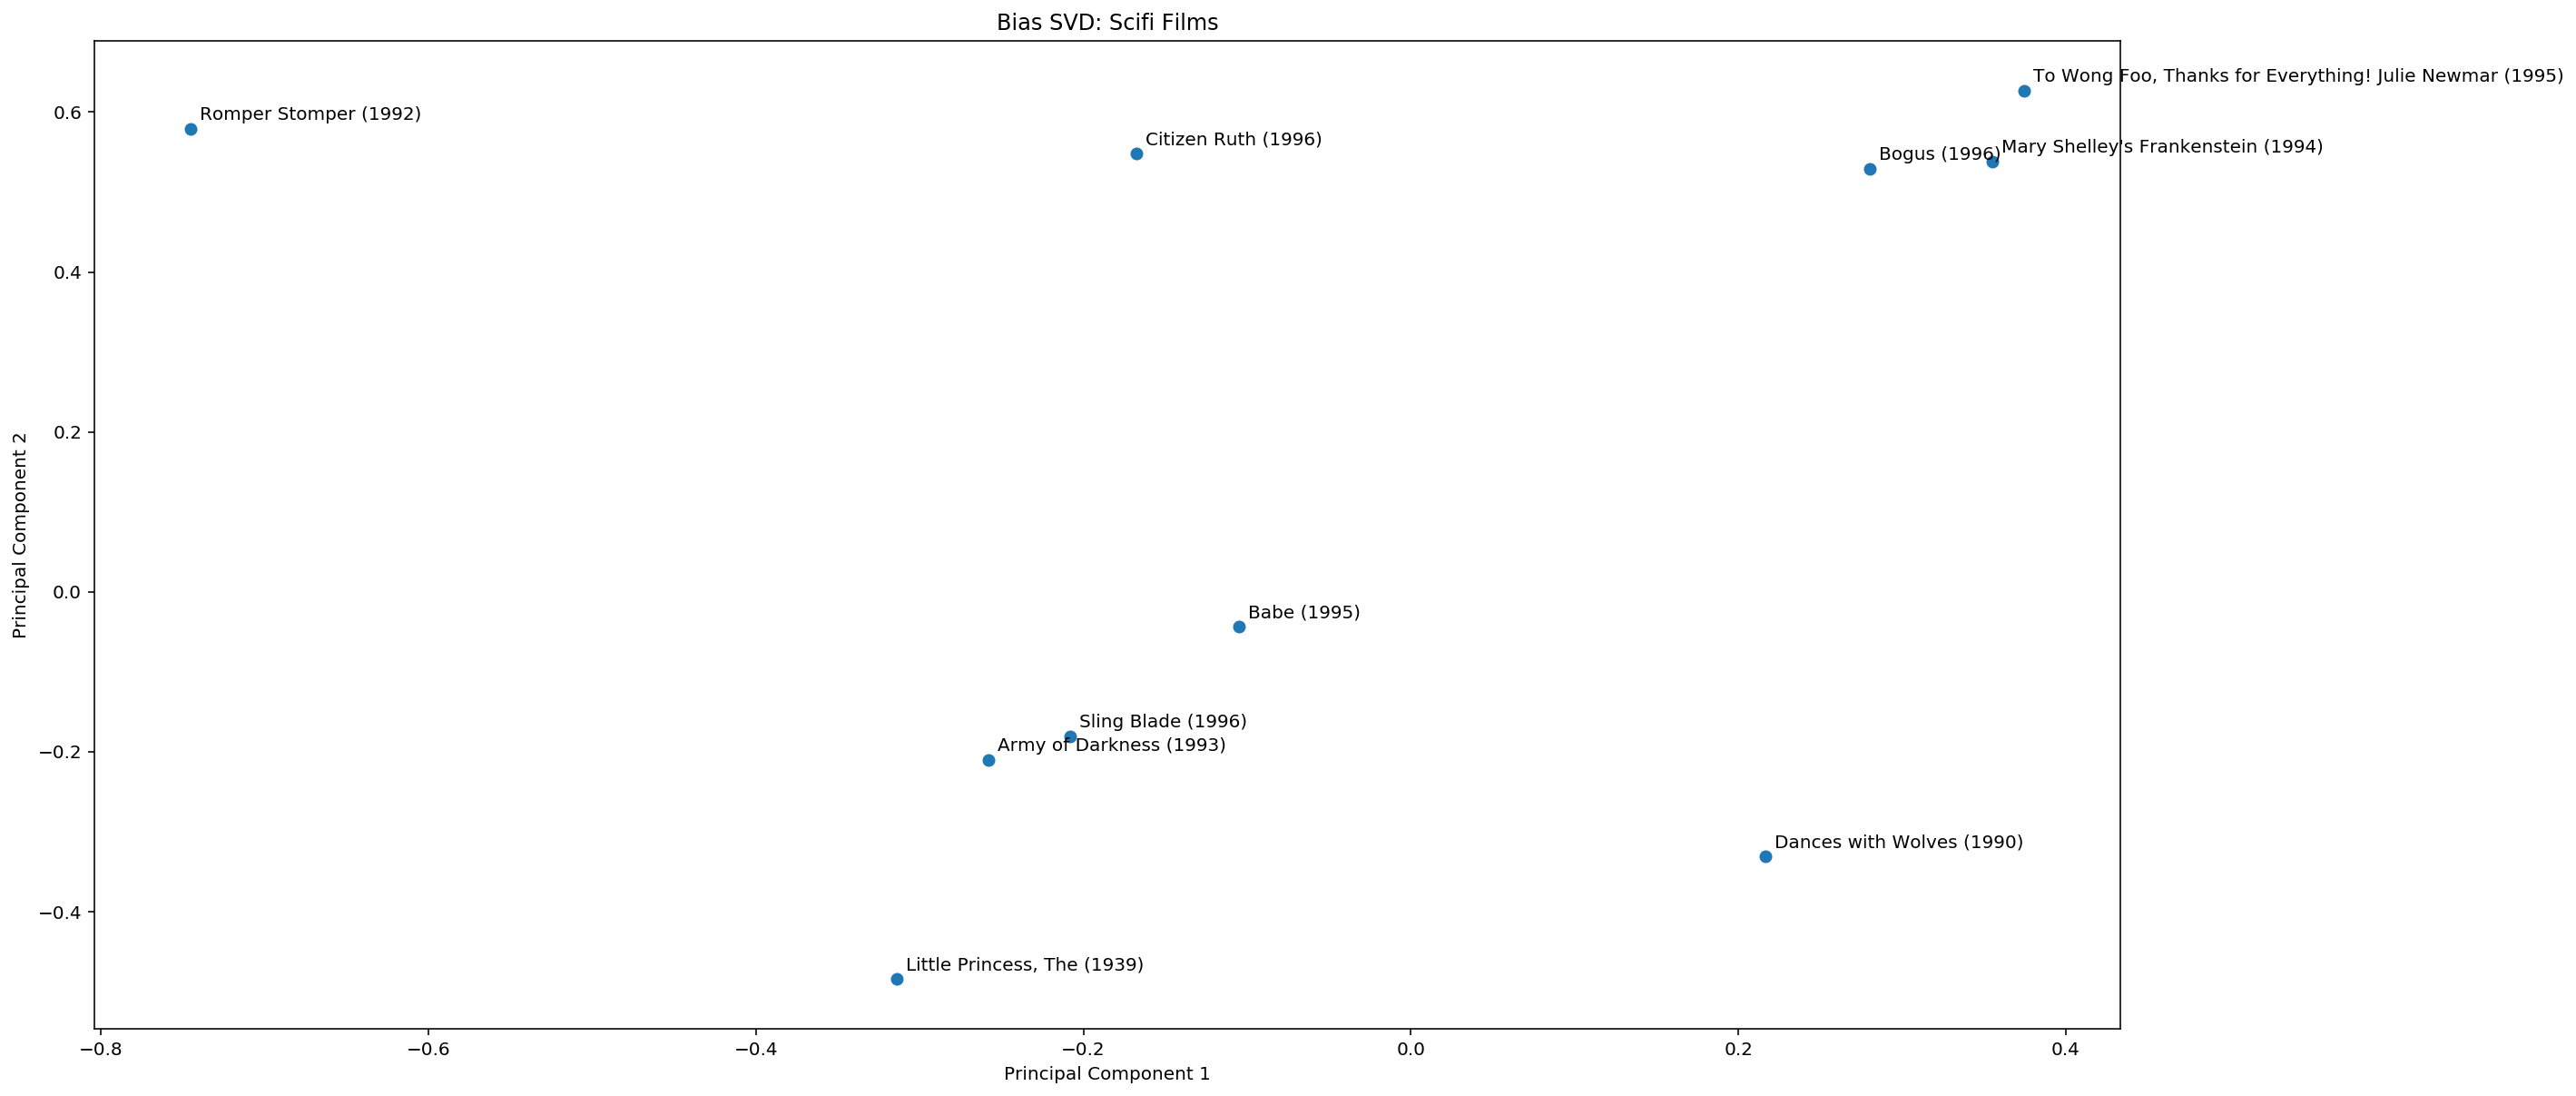

In [8]:
# actually perform the graphing of all the necessary things

# basic plots
matrix_visualize.plot_2d_projection_V(V_basic.T, df_movies, film_choices.get_popular(),
                                        "Basic SVD: Ten Most Popular Films")
matrix_visualize.plot_2d_projection_V(V_basic.T, df_movies, film_choices.get_highest(),
                                        "Basic SVD: Ten Highest Rated Popular Films")
matrix_visualize.plot_2d_projection_V(V_basic.T, df_movies, film_choices.random_ten(),
                                        "Basic SVD: Ten Random Films")
matrix_visualize.plot_2d_projection_V(V_basic.T, df_movies, film_choices.get_comedy(),
                                        "Basic SVD: Comedy Films")
matrix_visualize.plot_2d_projection_V(V_basic.T, df_movies, film_choices.get_action(),
                                        "Basic SVD: Action Films")
matrix_visualize.plot_2d_projection_V(V_basic.T, df_movies, film_choices.get_scifi(),
                                        "Basic SVD: Scifi Films")


# bias plots
matrix_visualize.plot_2d_projection_V(V_bias.T, df_movies, film_choices.get_popular(),
                                        "Bias SVD: Ten Most Popular Films")
matrix_visualize.plot_2d_projection_V(V_bias.T, df_movies, film_choices.get_highest(),
                                        "Bias SVD: Ten Highest Rated Films")
matrix_visualize.plot_2d_projection_V(V_bias.T, df_movies, film_choices.random_ten(),
                                        "Bias SVD: Ten Random Films")
matrix_visualize.plot_2d_projection_V(V_bias.T, df_movies, film_choices.get_comedy(),
                                        "Bias SVD: Comedy Films")
matrix_visualize.plot_2d_projection_V(V_bias.T, df_movies, film_choices.get_action(),
                                        "Bias SVD: Action Films")
matrix_visualize.plot_2d_projection_V(V_bias.T, df_movies, film_choices.get_scifi(),
                                        "Bias SVD: Scifi Films")